Based on:

1. S. Riddle, S. Köhler, and B. Ludäscher, “Towards constraint provenance games,” in 6th USENIX Workshop on the Theory and Practice of Provenance (TaPP 2014), 2014.

2. S. Köhler, B. Ludäscher, and D. Zinn, “First-order provenance games,” in In Search of Elegance in the Theory and Practice of Computation. Springer, 2013, pp. 382–399

#### Imports

In [1]:
# PWE
from PW_explorer.run_clingo import run_clingo
from PW_explorer.load_worlds import load_worlds
from PW_explorer.visualize import PWEVisualization
from PW_explorer.export import PWEExport
from PW_explorer.helper import rel_name_remapper

In [2]:
# Graphing and Visualization Libraries
import networkx as nx
from nxpd import draw
from nxpd import nxpdParams
nxpdParams['show'] = 'ipynb'

In [3]:
%load_ext PWE_NB_Extension

#### Helpers and Viz Functions

In [4]:
def simple_3hop_viz(pw_rel_dfs, gv_md):
    g = nx.MultiDiGraph()
    
    g.graph['rankdir'] = 'LR'
    hop_edges_color = gv_md['edge']['hop_2']['styles'][0][2]
    for i, row in pw_rel_dfs['hop_2'].iterrows():
        g.add_edge(row['x1'], row['x2'], color=hop_edges_color, style='dotted')
        
    thop_edges_color = gv_md['edge']['three_hop_2']['styles'][0][2]
    for i, row in pw_rel_dfs['three_hop_2'].iterrows():
        g.add_edge(row['x1'], row['x2'], color=thop_edges_color)
    return g

In [5]:
def get_prov_root_node(tail, head):
    return 'nth({},{})'.format(tail, head)

def get_prov_root_positive_node(tail, head):
    return 'th({},{})'.format(tail,head)

def remove_non_prov_edges(thop_prov_graph, inplace=False):
    if not inplace:
        thop_prov_graph = thop_prov_graph.copy()
    
    gray_edges_to_rm = []
    for e in thop_prov_graph.edges:
        if thop_prov_graph.edges[e]['color'] == 'gray':
            gray_edges_to_rm.append(e)
    thop_prov_graph.remove_edges_from(gray_edges_to_rm)
    
    return thop_prov_graph
    
def get_prov_subgraph(tail, head, thop_prov_graph):
    prov_root_node = get_prov_root_node(tail, head)
    prov_nodes = list(nx.descendants(thop_prov_graph, prov_root_node).union({prov_root_node}))
    prov_subgraph = thop_prov_graph.subgraph(prov_nodes)
    return prov_subgraph

In [6]:
from itertools import chain, combinations

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(1,len(s)+1))

In [7]:
NULL_NODE = 'NULL'
SEPARATOR = " "
CONSISTENT_NODE_COLOR = 'green'
INCONSISTENT_NODE_COLOR = 'red'
UNKNOWN_NODE_COLOR = 'black'

def node_to_set(n):
    return set(n.split(SEPARATOR))

def set_to_node(s):
    return SEPARATOR.join(sorted(list(s)))

def create_lattice(constraints):
    g = nx.DiGraph()
    g.add_node(NULL_NODE)
    curr_nodes_set = set(constraints)
    for cn in list(curr_nodes_set):
        g.add_edge(NULL_NODE, cn)
    curr_level = 1
    for _ in range(len(constraints)):
        next_level = curr_level + 1
        next_nodes_set = set([])
        curr_nodes_list = sorted(list(curr_nodes_set))
        for i in range(len(curr_nodes_list)):
            for j in range(i+1, len(curr_nodes_list)):
                n1 = node_to_set(curr_nodes_list[i])
                n2 = node_to_set(curr_nodes_list[j])
                n12 = n1.union(n2)
                if len(n12) == next_level:
                    next_nodes_set.add(set_to_node(n12))
                    g.add_edge(set_to_node(n1), set_to_node(n12))
                    g.add_edge(set_to_node(n2), set_to_node(n12))
        curr_level = next_level
        curr_nodes_set = next_nodes_set
    
    for n in g.nodes:
        g.nodes[n]['color'] = UNKNOWN_NODE_COLOR
        g.nodes[n]['label'] = '{}'.format(n)
        g.nodes[n]['pws'] = None
    
    return g

In [8]:
def get_successors(G, node):
    return set.union(*[set(x) for x in list(nx.dfs_successors(G, source=node).values())])

def get_predecessors(G, node):
    return set.union(*[set(x) for x in list(nx.dfs_predecessors(G, source=node).values())])

In [9]:
def draw_wfs_prov_graph(prov_wfs_exp):
    g = nx.DiGraph()
    
    for i, row in prov_wfs_exp['pw_rel_dfs']['w_1'].iterrows():
        node, stat = row['x1'], row['wfs_status']
        g.add_node(node, color='khaki1' if stat=='undefined' else 'palegreen')

    for i, row in prov_wfs_exp['pw_rel_dfs']['nw_1'].iterrows():
        node, stat = row['x1'], row['wfs_status']
        g.add_node(node, color='khaki1' if stat=='undefined' else 'indianred2')
    
    for n in g.nodes:
        g.nodes[n]['style'] = 'filled'
            
    for i, row in prov_wfs_exp['pw_rel_dfs']['p_3'].iterrows():
        col, tail, head, stat = row['x1'], row['x2'], row['x3'], row['wfs_status']
        g.add_edge(tail, head)
        if stat == 'undefined':
            g.edges[(tail,head)]['color'] = 'khaki1'
        else:
            g.edges[(tail,head)]['color'] = col
    
    for i, row in prov_wfs_exp['pw_rel_dfs']['non_p_3'].iterrows():
        col, tail, head, stat = row['x1'], row['x2'], row['x3'], row['wfs_status']
        g.add_edge(tail, head)
        if stat == 'undefined':
            g.edges[(tail,head)]['color'] = 'khaki1'
        else:
            g.edges[(tail,head)]['color'] = col
    
    return g

### Running Example: 3hop

#### Simple 3hop encoding:

In [10]:
%%clingo --donot-display_input -exp simple_instance

% graphviz graph graph_type=directed rankdir=LR
% graphviz edge hop(TAIL,HEAD) color=black

hop(a,a).
hop(a,b).
hop(b,a).
hop(b,c).

% graphviz edge three_hop(TAIL,HEAD) color=blue ord=2
three_hop(X,Y) :- hop(X,Z1), hop(Z1,Z2), hop(Z2,Y).

% #show three_hop/2.

Output:


'Answer: 1\nhop(a,a) hop(a,b) hop(b,a) hop(b,c) three_hop(a,a) three_hop(b,a) three_hop(a,b) three_hop(b,b) three_hop(a,c) three_hop(b,c)\nSATISFIABLE\n\nModels       : 1\nCalls        : 1\nTime         : 0.001s (Solving: 0.00s 1st Model: 0.00s Unsat: 0.00s)\nCPU Time     : 0.001s'

In [11]:
simple_instance['pw_rel_dfs'], simple_instance['rel_schemas'], simple_instance['pw_objects'] = load_worlds(simple_instance['asp_soln'], meta_data=simple_instance['meta_data'])

Number of Models: 1


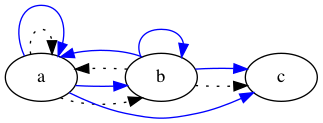

In [12]:
draw(simple_3hop_viz(simple_instance['pw_rel_dfs'], simple_instance['meta_data']['graphviz']))

The dotted-black edges are the input hop/2 facts and the blue arrows are the inferred three_hop/2 facts.

##### The above encoding gives us the solutions, however, there is no provenance information. For this we need a different encoding. We use a game-based evaluation that captures the provenance information as shown below.

### Provenance based Encoding

Expand each rule as follows:

<img src="Misc/Game-template.png" alt="Game-template" style="width: 600px;"/>

#### We can re-write the simple 3hop using the above encoding as below:

In [13]:
%%clingo --run --donot-display_input -exp thop -lci thop_prov_enc

% https://www.slideshare.net/ludaesch/towards-constraint-provenance-games
% slide #3 shows 3hop (th/2) rule: th(X,Y) :- hop(X,Z1), hop(Z1,Z2), hop(Z2,Y).
% slide #24 shows the why-not provenance of th(c,a)
% slide #25 shows a "what-if" provenance table => how to compute it?

% run with:
% dlv https://www.slideshare.net/ludaesch/towards-constraint-provenance-games


h(a,a).
h(a,b).
h(b,a).
h(b,c).

d(X) :- h(X,_).
d(X) :- h(_,X).

% Original rule (r1): 
% th(X,Y) :- h(X,Z1), h(Z1,Z2), h(Z2,Y).

% graphviz graph graph_type=directed

% Atom Complements for th/2 and h/2
m( nth(X,Y), th(X,Y) ) :- d(X), d(Y).
m( nh(X,Y),  h(X,Y) )  :- d(X), d(Y).

% EDB Facts
m( h(X,Y), rh(X,Y) )  :- h(X,Y).

% Head Atom to rule instance: 
m( th(X,Y), r1(X,Y,Z1,Z2) )  :- d(X), d(Y), d(Z1), d(Z2).

% Rule instance to subgoal (could simplify g_i/2 => g/2)
m( r1(X,Y,Z1,Z2), g1(X,Z1) )  :- d(X), d(Y), d(Z1), d(Z2).
m( r1(X,Y,Z1,Z2), g2(Z1,Z2) ) :- d(X), d(Y), d(Z1), d(Z2).
m( r1(X,Y,Z1,Z2), g3(Z2,Y) )  :- d(X), d(Y), d(Z1), d(Z2).

% Zwischenzug: Selected Goal -> "Goal is False" 
%% m( g1(X,Z1),  nh(X,Z1) )  :- h(X,Z1).
%% m( g2(Z1,Z2), nh(Z1,Z2) ) :- h(Z1,Z2).
%% m( g3(Z2,Y),  nh(Z2,Y) )  :- h(Z2,Y).
m( g1(X,Y),  nh(X,Y) )  :- d(X), d(Y).
m( g2(X,Y),  nh(X,Y) )  :- d(X), d(Y).
m( g3(X,Y),  nh(X,Y) )  :- d(X), d(Y).

gg_node(X) :- m(X,_).
gg_node(X) :- m(_,X).

% Solve Game: 
w(X) :- m(X,Y), not w(Y).
nw(X) :- not w(X), gg_node(X).

% graphviz node w(N) color=palegreen style=filled
% graphviz node nw(N) color=indianred2 style=filled

% p -> Provenance Edges
% graphviz edge p(_,HEAD,TAIL) color=$1
% Green edges:
p(green, X,Y) :- m(X,Y), w(X), not w(Y).
% Red edges:
p(red, X,Y) :- m(X,Y), not w(X), w(Y).
% Gray edges:
% graphviz edge non_p(_,HEAD,TAIL) color=$1 constraint=false
non_p(gray, X, Y) :- m(X,Y), w(X), w(Y).



Output:


'Answer: 1\nh(a,a) h(a,b) h(b,a) h(b,c) d(a) d(b) d(c) m(nth(a,a),th(a,a)) m(nth(b,a),th(b,a)) m(nth(c,a),th(c,a)) m(nth(a,b),th(a,b)) m(nth(b,b),th(b,b)) m(nth(c,b),th(c,b)) m(nth(a,c),th(a,c)) m(nth(b,c),th(b,c)) m(nth(c,c),th(c,c)) m(nh(a,a),h(a,a)) m(nh(b,a),h(b,a)) m(nh(c,a),h(c,a)) m(nh(a,b),h(a,b)) m(nh(b,b),h(b,b)) m(nh(c,b),h(c,b)) m(nh(a,c),h(a,c)) m(nh(b,c),h(b,c)) m(nh(c,c),h(c,c)) m(h(a,a),rh(a,a)) m(h(a,b),rh(a,b)) m(h(b,a),rh(b,a)) m(h(b,c),rh(b,c)) m(th(a,a),r1(a,a,a,a)) m(th(b,a),r1(b,a,a,a)) m(th(c,a),r1(c,a,a,a)) m(th(a,b),r1(a,b,a,a)) m(th(b,b),r1(b,b,a,a)) m(th(c,b),r1(c,b,a,a)) m(th(a,c),r1(a,c,a,a)) m(th(b,c),r1(b,c,a,a)) m(th(c,c),r1(c,c,a,a)) m(th(a,a),r1(a,a,b,a)) m(th(b,a),r1(b,a,b,a)) m(th(c,a),r1(c,a,b,a)) m(th(a,b),r1(a,b,b,a)) m(th(b,b),r1(b,b,b,a)) m(th(c,b),r1(c,b,b,a)) m(th(a,c),r1(a,c,b,a)) m(th(b,c),r1(b,c,b,a)) m(th(c,c),r1(c,c,b,a)) m(th(a,a),r1(a,a,c,a)) m(th(b,a),r1(b,a,c,a)) m(th(c,a),r1(c,a,c,a)) m(th(a,b),r1(a,b,c,a)) m(th(b,b),r1(b,b,c,a)) m(th(c,b),r1(c,b,c,a)) m(th(a,c),r1(a,c,c,a)) m(th(b,c),r1(b,c,c,a)) m(th(c,c),r1(c,c,c,a)) m(th(a,a),r1(a,a,a,b)) m(th(b,a),r1(b,a,a,b)) m(th(c,a),r1(c,a,a,b)) m(th(a,b),r1(a,b,a,b)) m(th(b,b),r1(b,b,a,b)) m(th(c,b),r1(c,b,a,b)) m(th(a,c),r1(a,c,a,b)) m(th(b,c),r1(b,c,a,b)) m(th(c,c),r1(c,c,a,b)) m(th(a,a),r1(a,a,b,b)) m(th(b,a),r1(b,a,b,b)) m(th(c,a),r1(c,a,b,b)) m(th(a,b),r1(a,b,b,b)) m(th(b,b),r1(b,b,b,b)) m(th(c,b),r1(c,b,b,b)) m(th(a,c),r1(a,c,b,b)) m(th(b,c),r1(b,c,b,b)) m(th(c,c),r1(c,c,b,b)) m(th(a,a),r1(a,a,c,b)) m(th(b,a),r1(b,a,c,b)) m(th(c,a),r1(c,a,c,b)) m(th(a,b),r1(a,b,c,b)) m(th(b,b),r1(b,b,c,b)) m(th(c,b),r1(c,b,c,b)) m(th(a,c),r1(a,c,c,b)) m(th(b,c),r1(b,c,c,b)) m(th(c,c),r1(c,c,c,b)) m(th(a,a),r1(a,a,a,c)) m(th(b,a),r1(b,a,a,c)) m(th(c,a),r1(c,a,a,c)) m(th(a,b),r1(a,b,a,c)) m(th(b,b),r1(b,b,a,c)) m(th(c,b),r1(c,b,a,c)) m(th(a,c),r1(a,c,a,c)) m(th(b,c),r1(b,c,a,c)) m(th(c,c),r1(c,c,a,c)) m(th(a,a),r1(a,a,b,c)) m(th(b,a),r1(b,a,b,c)) m(th(c,a),r1(c,a,b,c)) m(th(a,b),r1(a,b,b,c)) m(th(b,b),r1(b,b,b,c)) m(th(c,b),r1(c,b,b,c)) m(th(a,c),r1(a,c,b,c)) m(th(b,c),r1(b,c,b,c)) m(th(c,c),r1(c,c,b,c)) m(th(a,a),r1(a,a,c,c)) m(th(b,a),r1(b,a,c,c)) m(th(c,a),r1(c,a,c,c)) m(th(a,b),r1(a,b,c,c)) m(th(b,b),r1(b,b,c,c)) m(th(c,b),r1(c,b,c,c)) m(th(a,c),r1(a,c,c,c)) m(th(b,c),r1(b,c,c,c)) m(th(c,c),r1(c,c,c,c)) m(r1(a,a,a,a),g1(a,a)) m(r1(b,a,a,a),g1(b,a)) m(r1(c,a,a,a),g1(c,a)) m(r1(a,b,a,a),g1(a,a)) m(r1(b,b,a,a),g1(b,a)) m(r1(c,b,a,a),g1(c,a)) m(r1(a,c,a,a),g1(a,a)) m(r1(b,c,a,a),g1(b,a)) m(r1(c,c,a,a),g1(c,a)) m(r1(a,a,b,a),g1(a,b)) m(r1(b,a,b,a),g1(b,b)) m(r1(c,a,b,a),g1(c,b)) m(r1(a,b,b,a),g1(a,b)) m(r1(b,b,b,a),g1(b,b)) m(r1(c,b,b,a),g1(c,b)) m(r1(a,c,b,a),g1(a,b)) m(r1(b,c,b,a),g1(b,b)) m(r1(c,c,b,a),g1(c,b)) m(r1(a,a,c,a),g1(a,c)) m(r1(b,a,c,a),g1(b,c)) m(r1(c,a,c,a),g1(c,c)) m(r1(a,b,c,a),g1(a,c)) m(r1(b,b,c,a),g1(b,c)) m(r1(c,b,c,a),g1(c,c)) m(r1(a,c,c,a),g1(a,c)) m(r1(b,c,c,a),g1(b,c)) m(r1(c,c,c,a),g1(c,c)) m(r1(a,a,a,b),g1(a,a)) m(r1(b,a,a,b),g1(b,a)) m(r1(c,a,a,b),g1(c,a)) m(r1(a,b,a,b),g1(a,a)) m(r1(b,b,a,b),g1(b,a)) m(r1(c,b,a,b),g1(c,a)) m(r1(a,c,a,b),g1(a,a)) m(r1(b,c,a,b),g1(b,a)) m(r1(c,c,a,b),g1(c,a)) m(r1(a,a,b,b),g1(a,b)) m(r1(b,a,b,b),g1(b,b)) m(r1(c,a,b,b),g1(c,b)) m(r1(a,b,b,b),g1(a,b)) m(r1(b,b,b,b),g1(b,b)) m(r1(c,b,b,b),g1(c,b)) m(r1(a,c,b,b),g1(a,b)) m(r1(b,c,b,b),g1(b,b)) m(r1(c,c,b,b),g1(c,b)) m(r1(a,a,c,b),g1(a,c)) m(r1(b,a,c,b),g1(b,c)) m(r1(c,a,c,b),g1(c,c)) m(r1(a,b,c,b),g1(a,c)) m(r1(b,b,c,b),g1(b,c)) m(r1(c,b,c,b),g1(c,c)) m(r1(a,c,c,b),g1(a,c)) m(r1(b,c,c,b),g1(b,c)) m(r1(c,c,c,b),g1(c,c)) m(r1(a,a,a,c),g1(a,a)) m(r1(b,a,a,c),g1(b,a)) m(r1(c,a,a,c),g1(c,a)) m(r1(a,b,a,c),g1(a,a)) m(r1(b,b,a,c),g1(b,a)) m(r1(c,b,a,c),g1(c,a)) m(r1(a,c,a,c),g1(a,a)) m(r1(b,c,a,c),g1(b,a)) m(r1(c,c,a,c),g1(c,a)) m(r1(a,a,b,c),g1(a,b)) m(r1(b,a,b,c),g1(b,b)) m(r1(c,a,b,c),g1(c,b)) m(r1(a,b,b,c),g1(a,b)) m(r1(b,b,b,c),g1(b,b)) m(r1(c,b,b,c),g1(c,b)) m(r1(a,c,b,c),g1(a,b)) m(r1(b,c,b,c),g1(b,b)) m(r1(c,c,b,c),g1(c,b)) m(r1(a,a,c,c

Large output, we can check that it gives the same solution as we expect as follows:

In [14]:
%%clingo -l thop_prov_enc --donot-display_input

thop(X,Y) :- w(th(X,Y)).
#show thop/2.

Output:


'Answer: 1\nthop(a,a) thop(b,a) thop(a,b) thop(b,b) thop(a,c) thop(b,c)\nSATISFIABLE\n\nModels       : 1\nCalls        : 1\nTime         : 0.008s (Solving: 0.00s 1st Model: 0.00s Unsat: 0.00s)\nCPU Time     : 0.008s'

Same output as before.

In [15]:
# Load into PWE
pw_rel_dfs, rel_schemas, pw_objects = load_worlds(thop['asp_soln'], meta_data=thop['meta_data'])

Number of Models: 1


Now we can see the provenance graph as shown below:

In [16]:
thop_prov_graph = PWEVisualization.graphviz_from_meta_data(pw_rel_dfs, thop['meta_data']['graphviz'])

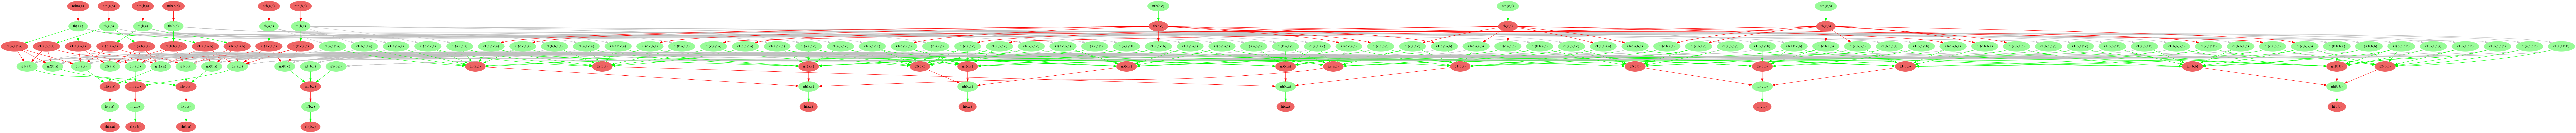

In [17]:
draw(thop_prov_graph)

We can remove the non-provenance edges:

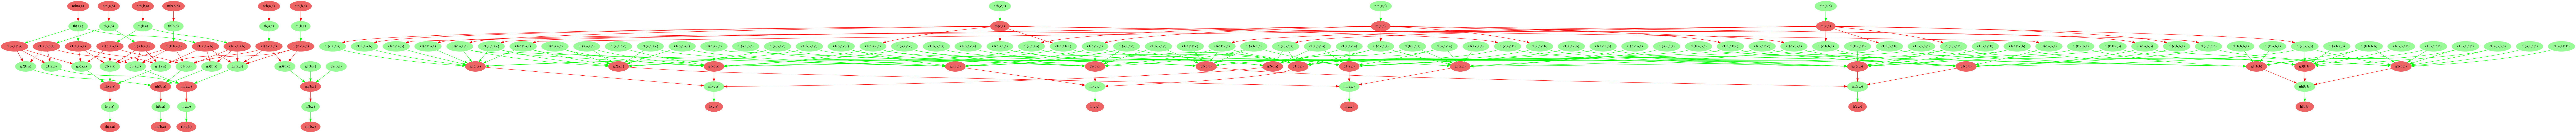

In [18]:
thop_prov_graph = remove_non_prov_edges(thop_prov_graph, inplace=True)
draw(thop_prov_graph)

Here, we can see there are two (weakly-connected) components, one for the failed three_hop evaluations and one for the successful ones.

Component: 1


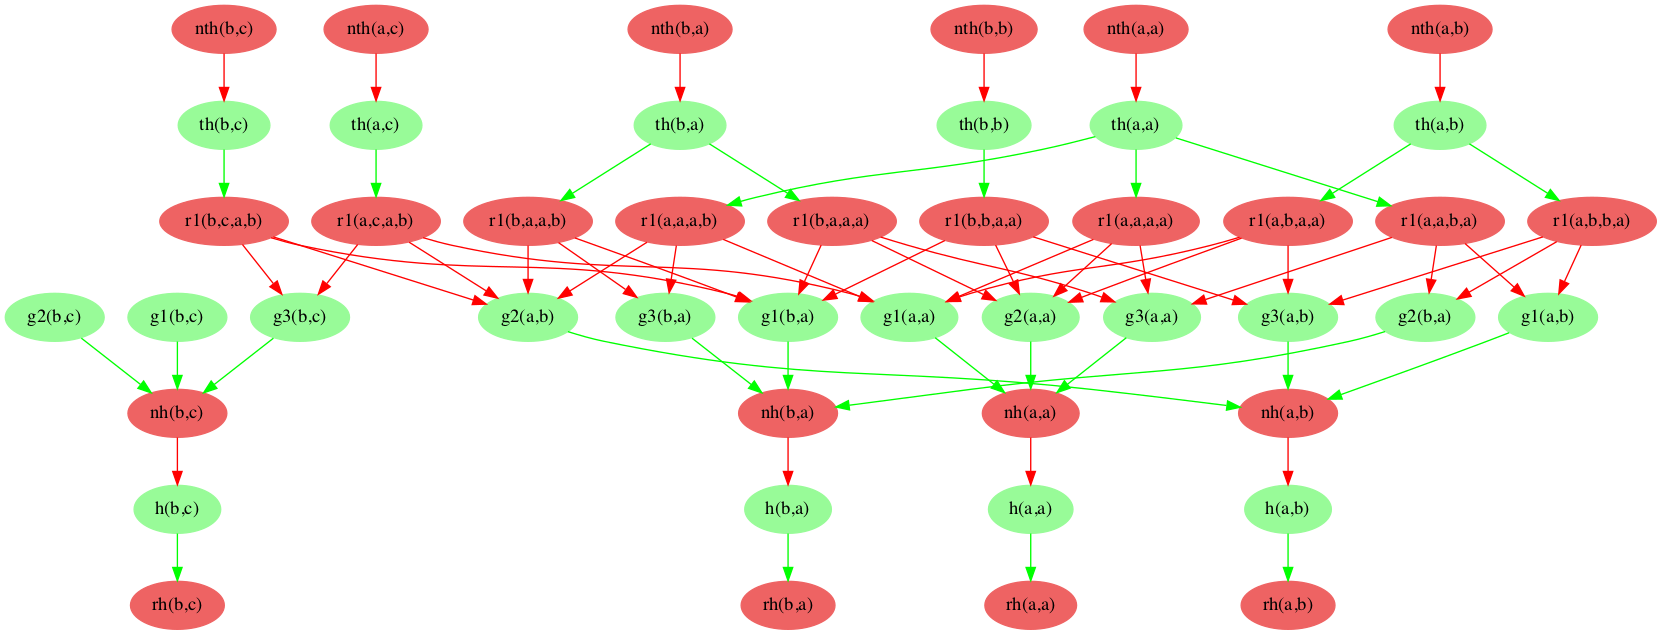

Component: 2


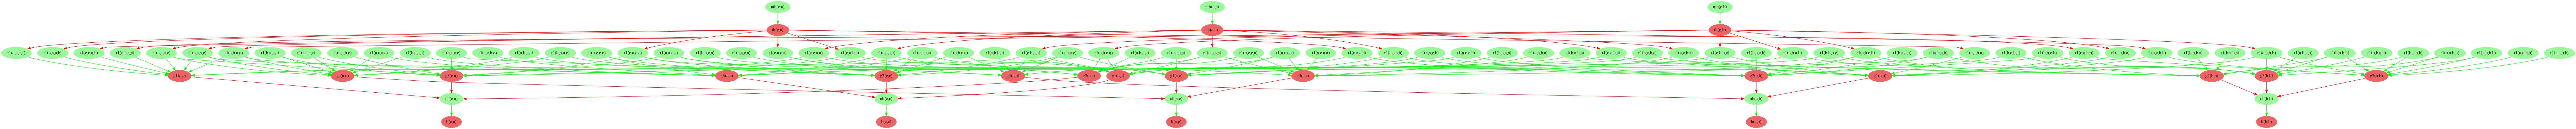

In [19]:
weakly_connc_comps = list(nx.components.weakly_connected_components(thop_prov_graph))
weakly_connc_comps = [nx.subgraph(thop_prov_graph, x) for x in weakly_connc_comps]
for i, wcc in enumerate(weakly_connc_comps):
    print("Component: {}".format(str(i+1)))
    display(draw(wcc))

#### Now, for any of the decisions (i.e. whether 3hop(X,Y) is TRUE), we can check the provenance for the decision.

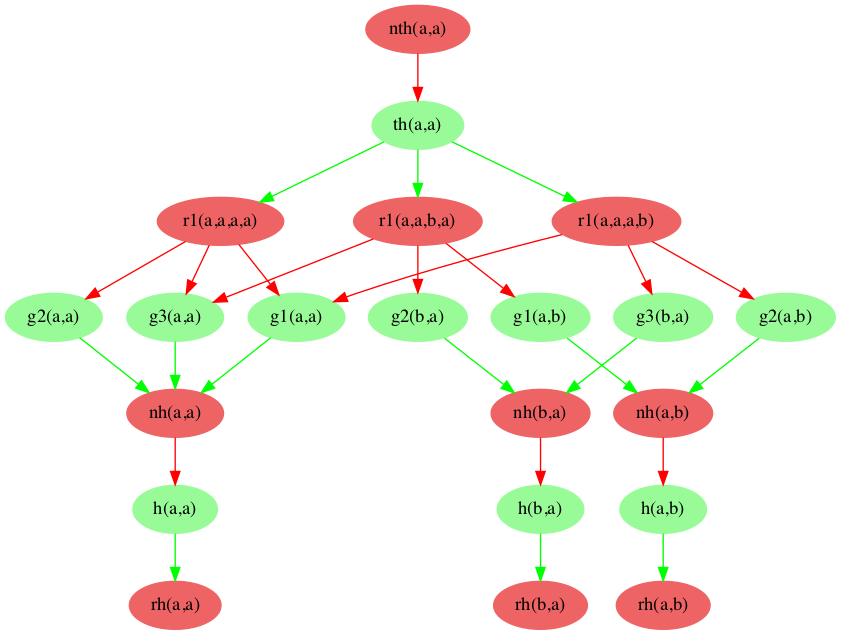

In [20]:
# WHY PROV:
thop_node_to_check = ('a', 'a')
draw(get_prov_subgraph(*thop_node_to_check, thop_prov_graph))

In [ ]:
# draw(get_prov_subgraph(*thop_node_to_check, thop_prov_graph), filename='why-prov-th-aa.pdf', show=False)

Above, we can see the provenance information for 3hop(a,b) i.e. why it is true. It is true because rule-1 (r1 as defined in encoding) fires successfully.

r1(a,a,b,a) $\implies$ a$\rightarrow$b$\rightarrow$a$\rightarrow$b

r1(a,a,a,b) $\implies$ a$\rightarrow$a$\rightarrow$b$\rightarrow$a

r1(a,a,a,a) $\implies$ a$\rightarrow$a$\rightarrow$a$\rightarrow$a

i.e r1(X,Y,Z1,Z2) $\implies$ X$\rightarrow$Z1$\rightarrow$Z2$\rightarrow$Y

Note that just one of them is enough for 3hop(a,b) to be TRUE.

#### Even more importantly, we can now see why a certain 3hop decision is FALSE i.e. trace the WHY-NOT Provenance.

Focus on Why-Not Provenance for 3hop(c,a)

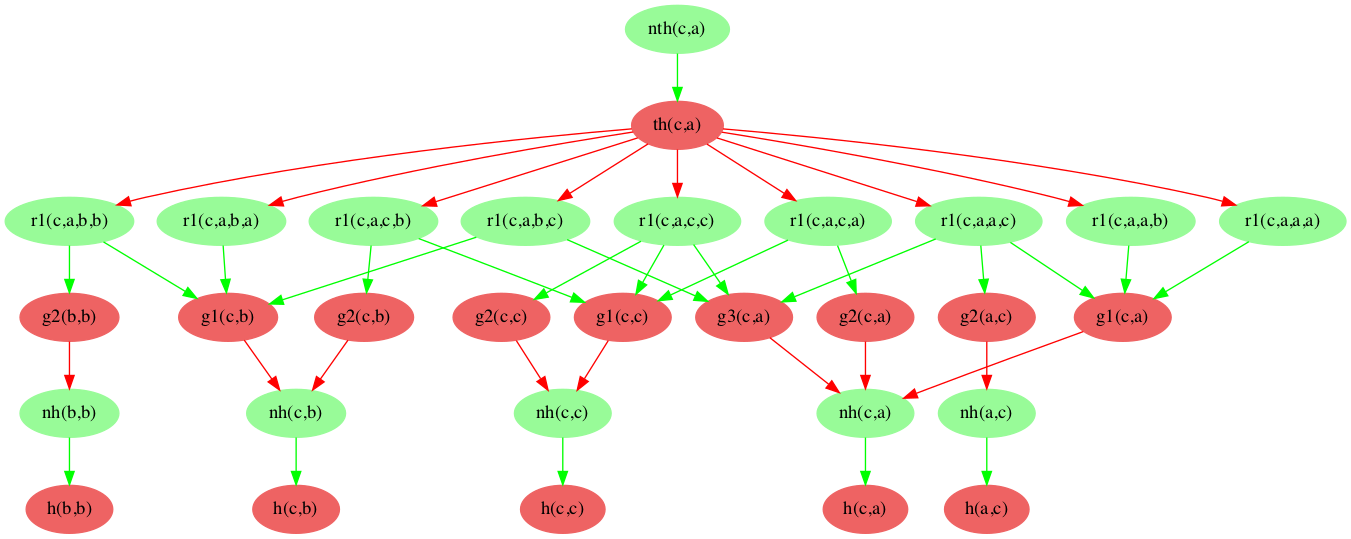

In [22]:
# WHY NOT PROV
thop_node_to_check = ('c', 'a')
why_not_prov_subgraph = get_prov_subgraph(*thop_node_to_check, thop_prov_graph)
draw(why_not_prov_subgraph)

In [ ]:
# draw(why_not_prov_subgraph, filename='why-not-prov-th-ca.pdf', show=False)

Above is the why-not provenance for 3hop(c,a). We can see that it tries all the possible r1 assignments, but they all fail due to some missing hop/2 node (also shown in the graph). That is why 3hop(c,a) is not true.

In [24]:
failed_rule_assignments = list(nx.neighbors(why_not_prov_subgraph, get_prov_root_positive_node(*thop_node_to_check)))
failed_rule_assignments

['r1(c,a,a,a)',
 'r1(c,a,b,a)',
 'r1(c,a,c,a)',
 'r1(c,a,a,b)',
 'r1(c,a,b,b)',
 'r1(c,a,c,b)',
 'r1(c,a,a,c)',
 'r1(c,a,b,c)',
 'r1(c,a,c,c)']

In [25]:
failed_rule_assignments = [x[x.find('(')+1:x.find(')')].split(',') for x in failed_rule_assignments]
failed_rule_assignments = ["{} --> {} --> {} --> {}".format(x[0],x[2],x[3],x[1]) for x in failed_rule_assignments]
print("Failed Trials:\n\n{}".format("\n".join(failed_rule_assignments)))

Failed Trials:

c --> a --> a --> a
c --> b --> a --> a
c --> c --> a --> a
c --> a --> b --> a
c --> b --> b --> a
c --> c --> b --> a
c --> a --> c --> a
c --> b --> c --> a
c --> c --> c --> a


Above are the failed trials to satisfy 3hop(c,a). For example r1(c,a,a,a) failed because hop(c,a) was missing.

Below is the list of "missing" hop facts that in some way contribute to 3hop(c,a) not being true. "Failed" Facts appear at the leaves (since all leaves are failed by default).

In [26]:
thop_failed_leaves = list(filter(lambda x: why_not_prov_subgraph.out_degree(x) == 0, why_not_prov_subgraph.nodes))
thop_failed_leaves

['h(b,b)', 'h(c,c)', 'h(a,c)', 'h(c,b)', 'h(c,a)']

### What-If Provenance

Another interesting to find would be to see what would be the provenance had a a certain "fact" or some constraint been present (or absent). Using this encoding we can do this as well (upto a degree).

#### Trying to do it within the ASP program
One natural thing to do might be to do this within the same program by evaluating the "missing" hops and adding them (or a subset of them) in as follows:

In [27]:
%%clingo -l thop_prov_enc --donot-display_input

% WHAT IF PROV: TRIAL 1

%% Compute the missing hops:
% Missing hops: 
mi(h(X,Y)) :- p(green, nh(X,Y), h(X,Y)).

% Invent missing h/2 edges and add them in:
h(X,Y) :- mi(h(X,Y)).

Output:


'UNSATISFIABLE\n\nModels       : 0\nCalls        : 1\nTime         : 0.011s (Solving: 0.00s 1st Model: 0.00s Unsat: 0.00s)\nCPU Time     : 0.011s'

Doesn't work! Why?

Let's take a look at the Rule-Goal-Graph for this rule-set:

<img src="Misc/rule-goal-graph.png" alt="Game-template" style="width: 900px;"/>

As we can see, adding the two rules above leads to a contradiction. We can trace this in the rule-goal-graph above. Observe first that these rules create an infinite loop. Moreover, the contradiction occurs because of r3 (and in part r2) in conjunction with the newly added rules. r3 is the "game rule" i.e. the master equation that decides whether an atom instance is true (win) or false (fail). Into it, a hop fact enters (through m/2 as a proxy but it is one to one so we can consider it entering as is) and is classified as true or false (all base hop facts are true). The "missing" hops are classified as "false". However, if we take those and now "declare" them to be true, it contradicts with the current model, and hence we get an "unsatisfiable" instance.

So clearly, we cannot do this within the same program (at least not in the way we have above).

#### What-if Prov using after-the-fact additions

So we need to add these "missing" hop relations in "after the fact" i.e. separately. Thanks to PWE, we can do that automagically over all possible combinations.

First let's calculate the "missing" facts like before:

In [28]:
%%clingo -l thop_prov_enc --donot-display_input -exp missing_hop_comp

mi(h(X,Y)) :- p(green, nh(X,Y), h(X,Y)).
missing_hop(X,Y) :- mi(h(X,Y)).
#show missing_hop/2.

Output:


'Answer: 1\nmissing_hop(c,a) missing_hop(b,b) missing_hop(c,b) missing_hop(a,c) missing_hop(c,c)\nSATISFIABLE\n\nModels       : 1\nCalls        : 1\nTime         : 0.009s (Solving: 0.00s 1st Model: 0.00s Unsat: 0.00s)\nCPU Time     : 0.008s'

In [29]:
missing_hop_comp['pw_rel_dfs'], missing_hop_comp['rel_schema'], missing_hop_comp['pw_objs'] = load_worlds(missing_hop_comp['asp_soln'], silent=True)
#[(row['x1'], row['x2']) for _, row in missing_hop_comp['pw_rel_dfs']['missing_hop_2'].iterrows()]
rel_name_remapper(missing_hop_comp['pw_rel_dfs'], missing_hop_comp['pw_objs'], missing_hop_comp['rel_schema'], {'missing_hop_2': 'h_2'}, pws_inplace=True, rels_inplace=True)
missing_hops = PWEExport.export_as_asp_facts(missing_hop_comp['pw_objs'], include_pw_ids=False)
missing_hops

['h(c,a).', 'h(b,b).', 'h(c,b).', 'h(a,c).', 'h(c,c).']

We can now create a powerset of these missing hop facts.

In [30]:
mh_powerset = list(powerset(missing_hops))

In [31]:
what_if_prov_lattice = create_lattice(missing_hops)

As before, let's focus on the what-if provenance of 3hop(c,a) i.e. see if 3hop(c,a) would be true or false and why on adding a certain set of hop facts.

Hop(s) added: h(c,a).
th(c,a) Satisfied
Provenance Subgraph:


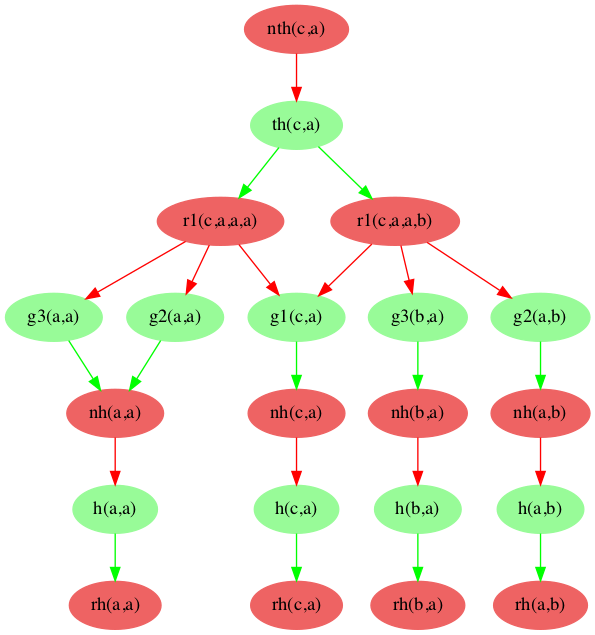

Hop(s) added: h(b,b).
th(c,a) Not satisfied
Provenance Subgraph:


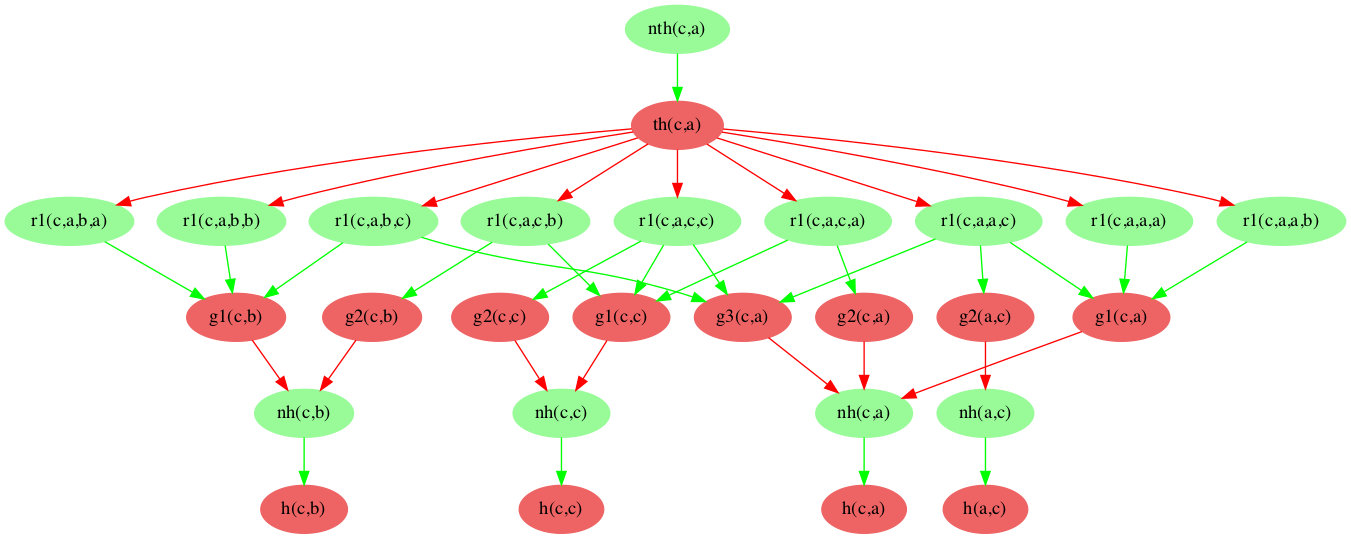

Hop(s) added: h(c,b).
th(c,a) Satisfied
Provenance Subgraph:


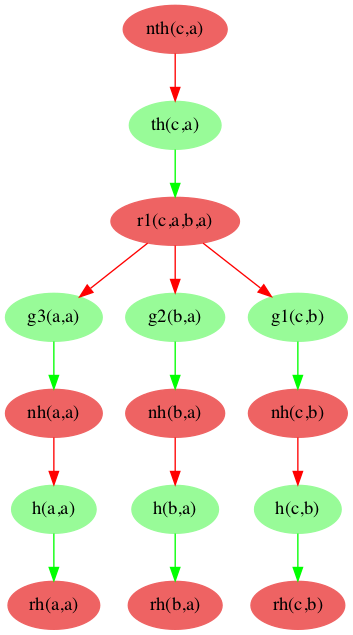

Hop(s) added: h(a,c).
th(c,a) Not satisfied
Provenance Subgraph:


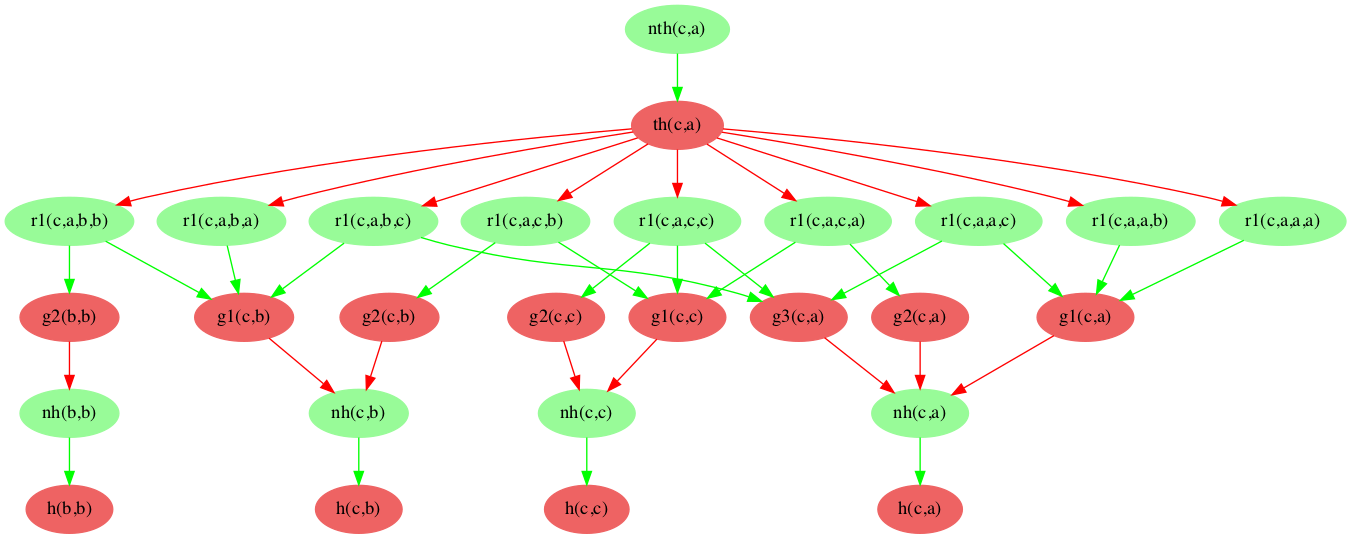

Hop(s) added: h(c,c).
th(c,a) Not satisfied
Provenance Subgraph:


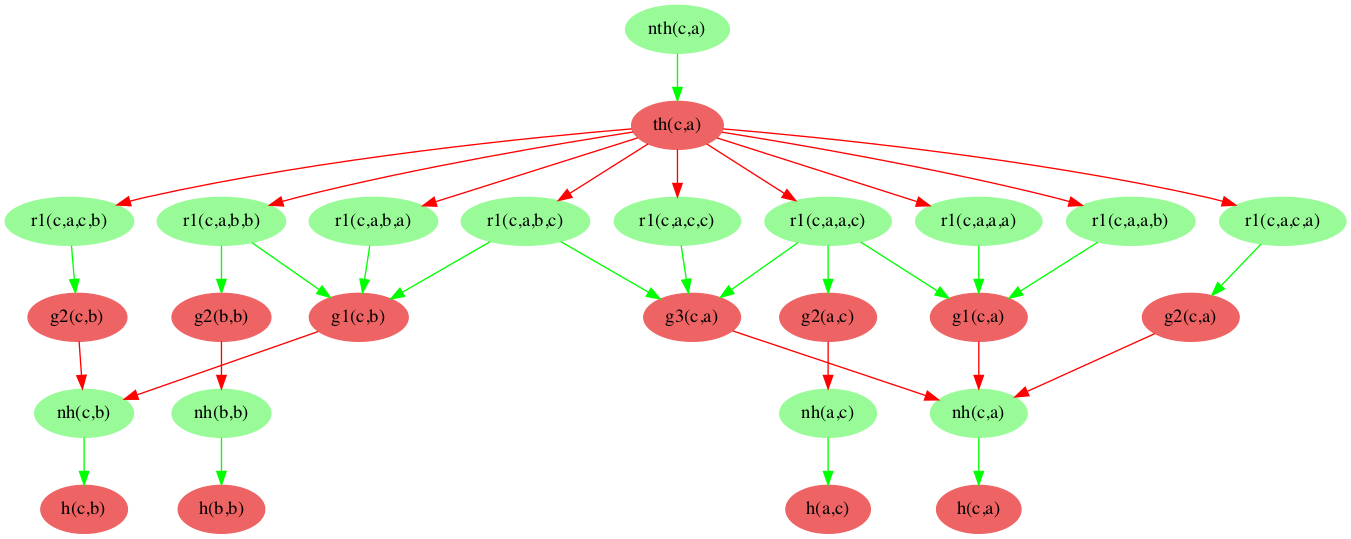

Hop(s) added: h(c,a). h(b,b).
th(c,a) Satisfied
Provenance Subgraph:


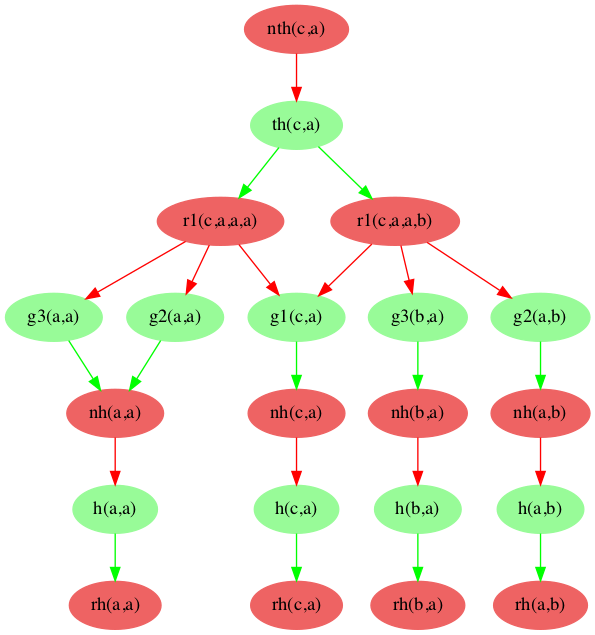

Hop(s) added: h(c,a). h(c,b).
th(c,a) Satisfied
Provenance Subgraph:


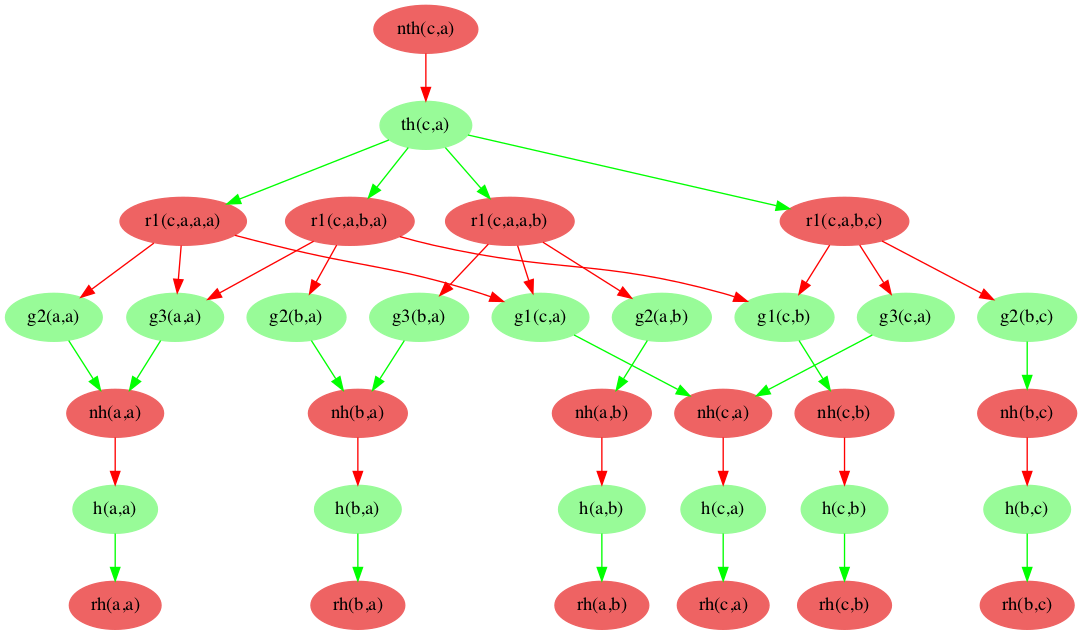

Hop(s) added: h(c,a). h(a,c).
th(c,a) Satisfied
Provenance Subgraph:


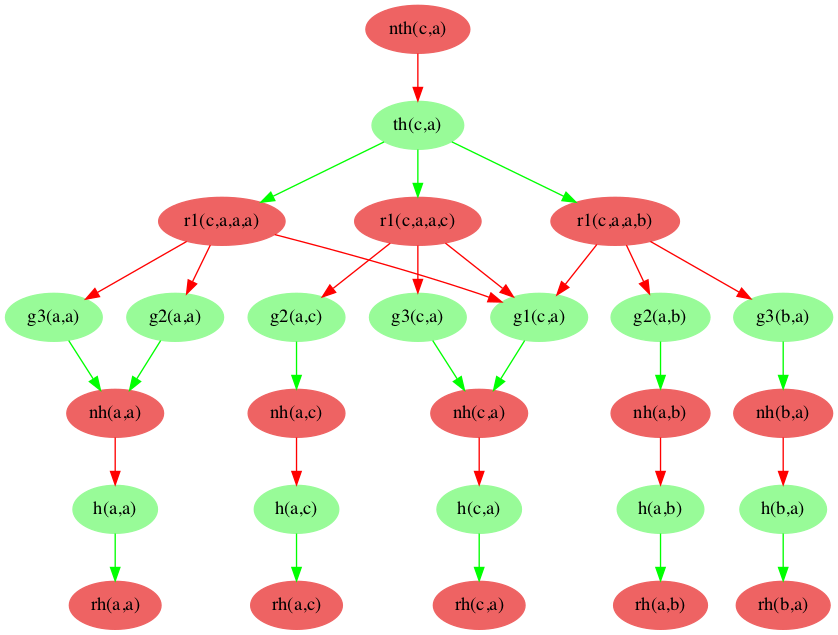

Hop(s) added: h(c,a). h(c,c).
th(c,a) Satisfied
Provenance Subgraph:


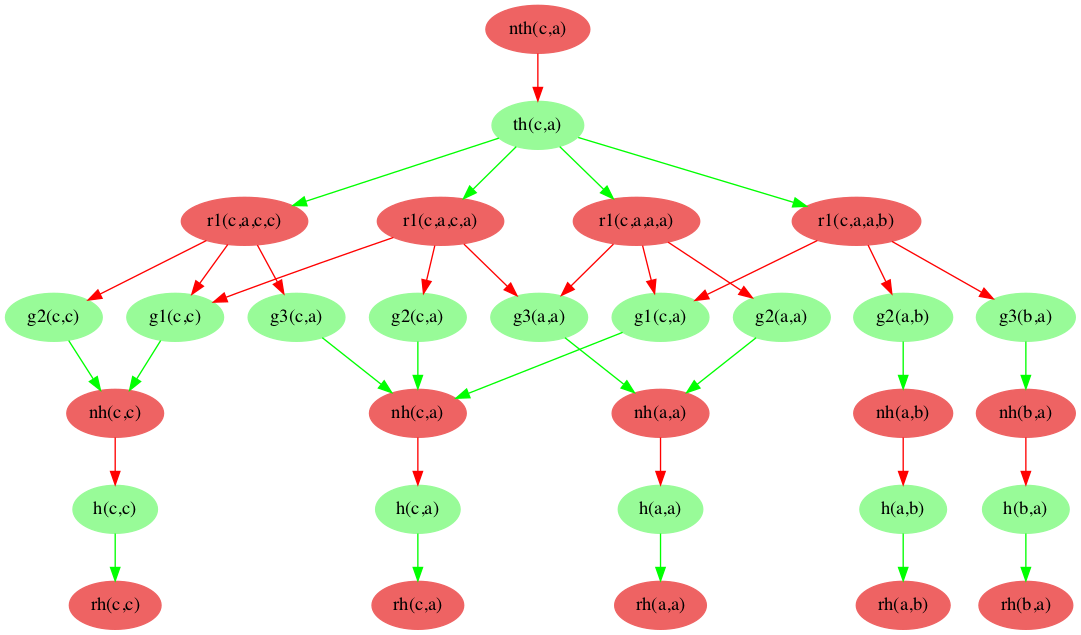

Hop(s) added: h(b,b). h(c,b).
th(c,a) Satisfied
Provenance Subgraph:


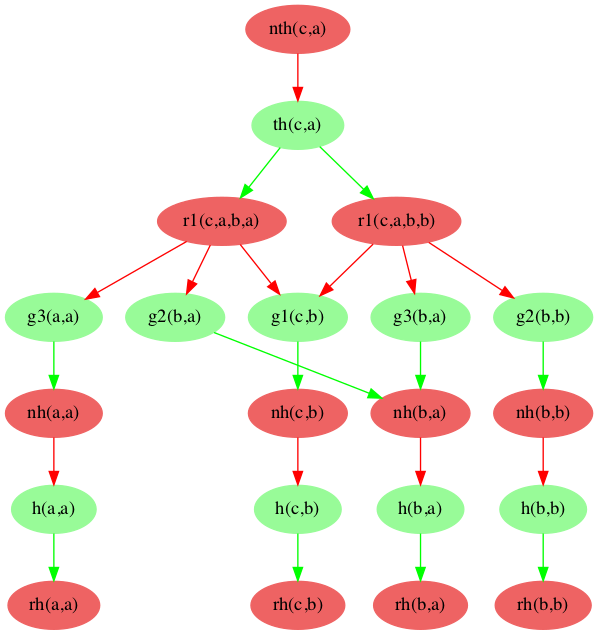

Hop(s) added: h(b,b). h(a,c).
th(c,a) Not satisfied
Provenance Subgraph:


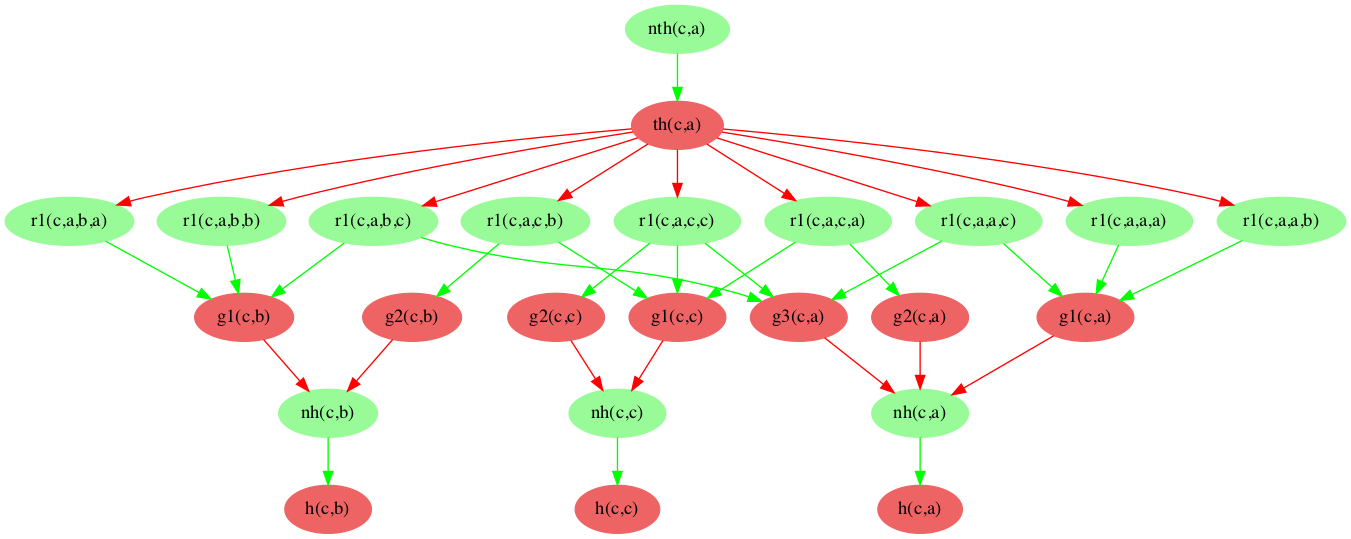

Hop(s) added: h(b,b). h(c,c).
th(c,a) Not satisfied
Provenance Subgraph:


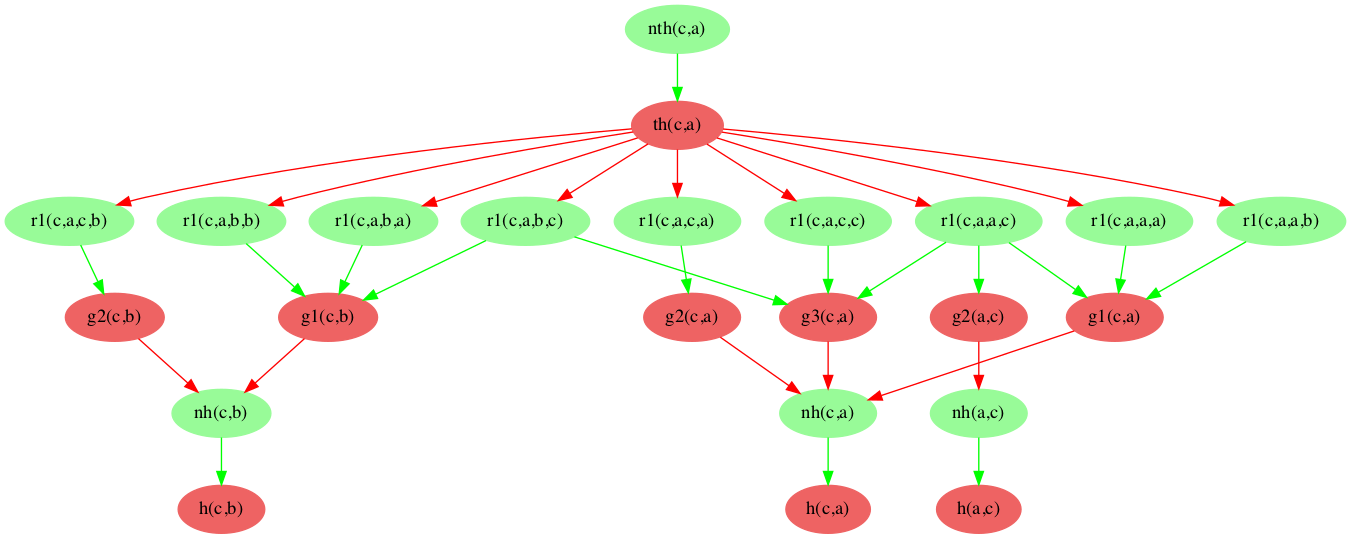

Hop(s) added: h(c,b). h(a,c).
th(c,a) Satisfied
Provenance Subgraph:


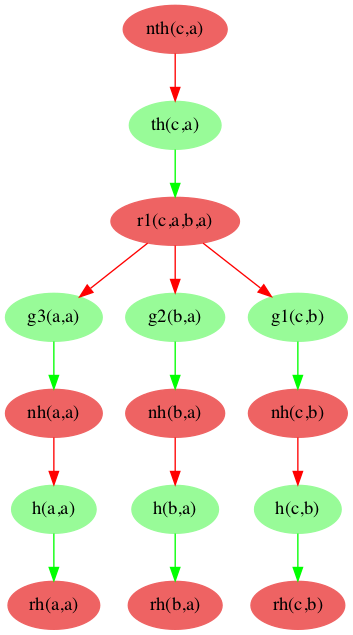

Hop(s) added: h(c,b). h(c,c).
th(c,a) Satisfied
Provenance Subgraph:


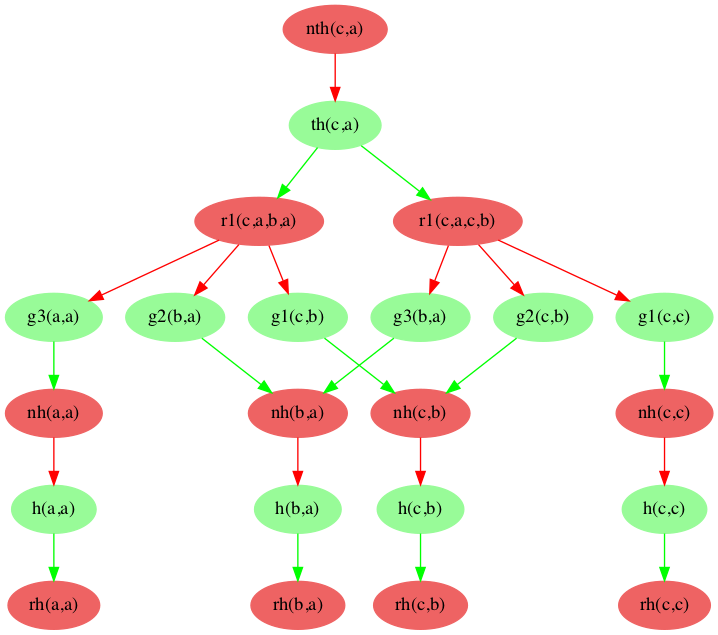

Hop(s) added: h(a,c). h(c,c).
th(c,a) Not satisfied
Provenance Subgraph:


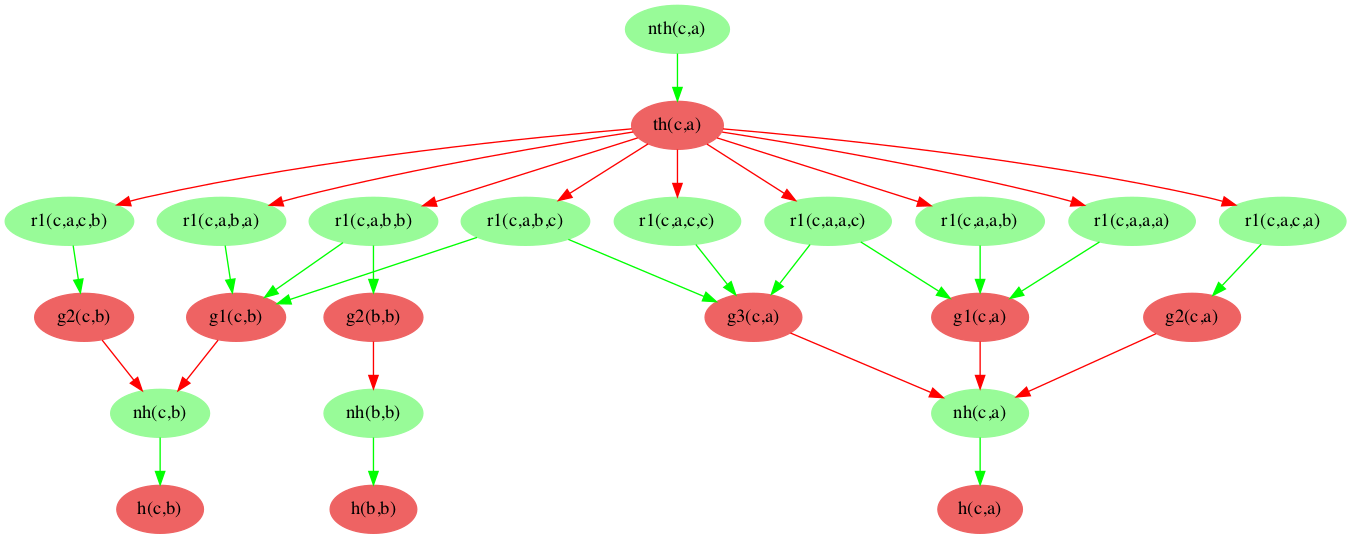

Hop(s) added: h(c,a). h(b,b). h(c,b).
th(c,a) Satisfied
Provenance Subgraph:


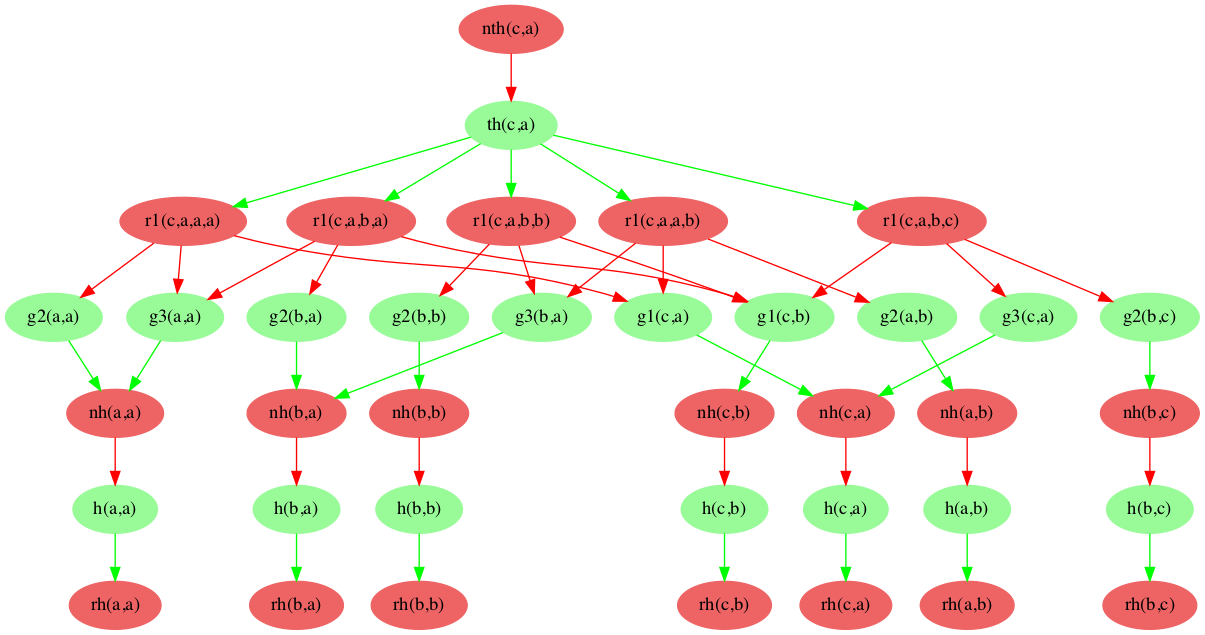

Hop(s) added: h(c,a). h(b,b). h(a,c).
th(c,a) Satisfied
Provenance Subgraph:


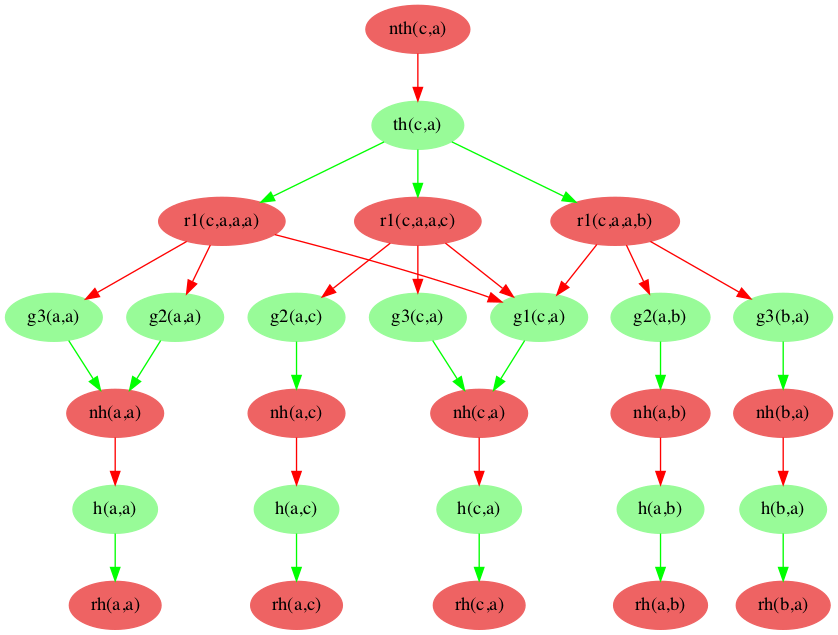

Hop(s) added: h(c,a). h(b,b). h(c,c).
th(c,a) Satisfied
Provenance Subgraph:


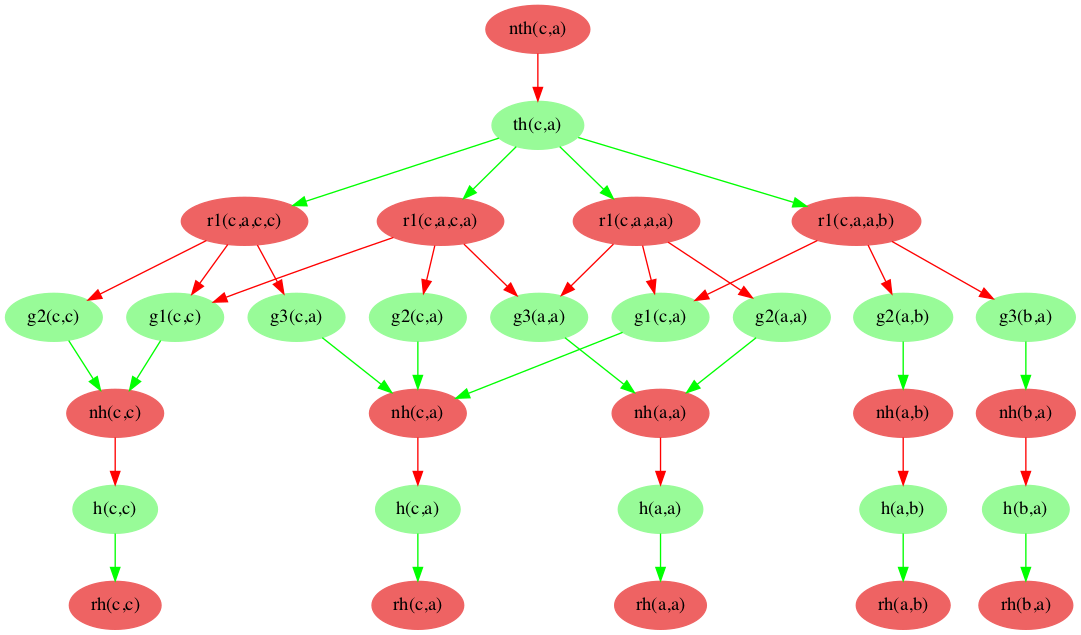

Hop(s) added: h(c,a). h(c,b). h(a,c).
th(c,a) Satisfied
Provenance Subgraph:


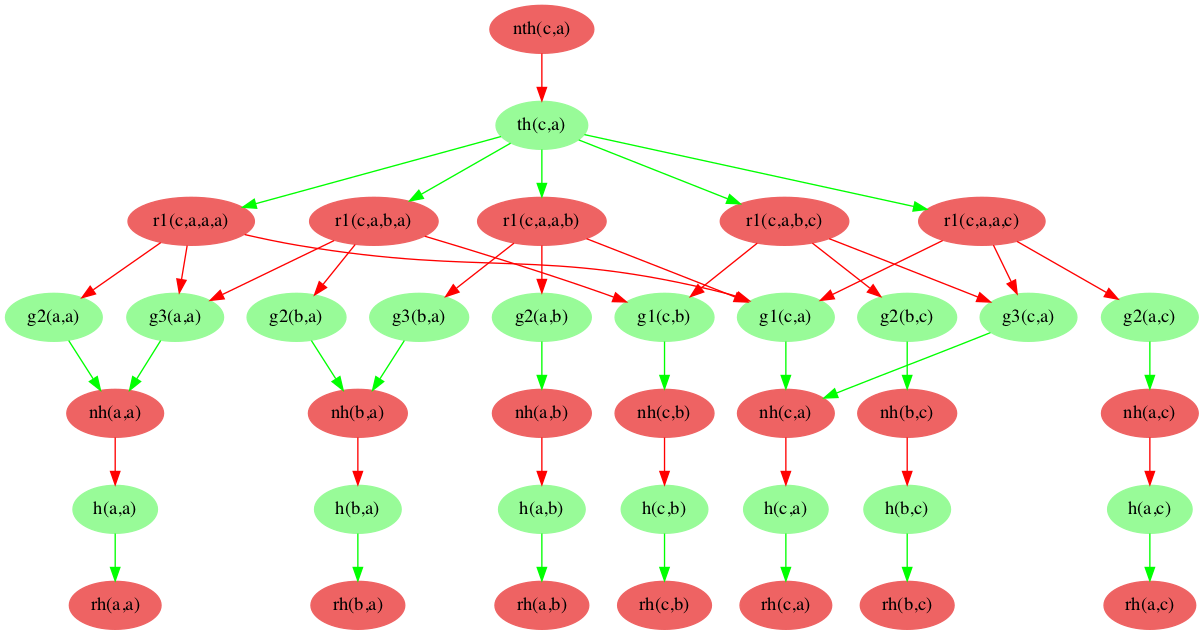

Hop(s) added: h(c,a). h(c,b). h(c,c).
th(c,a) Satisfied
Provenance Subgraph:


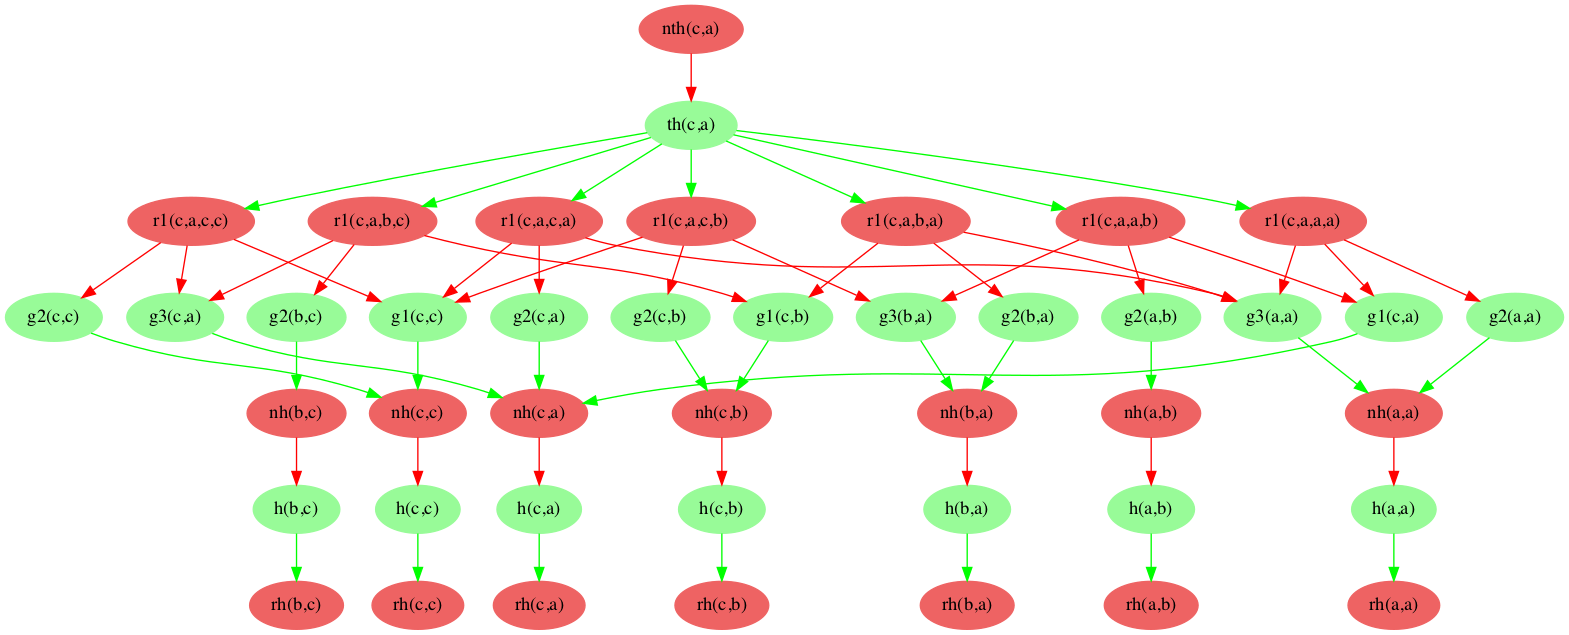

Hop(s) added: h(c,a). h(a,c). h(c,c).
th(c,a) Satisfied
Provenance Subgraph:


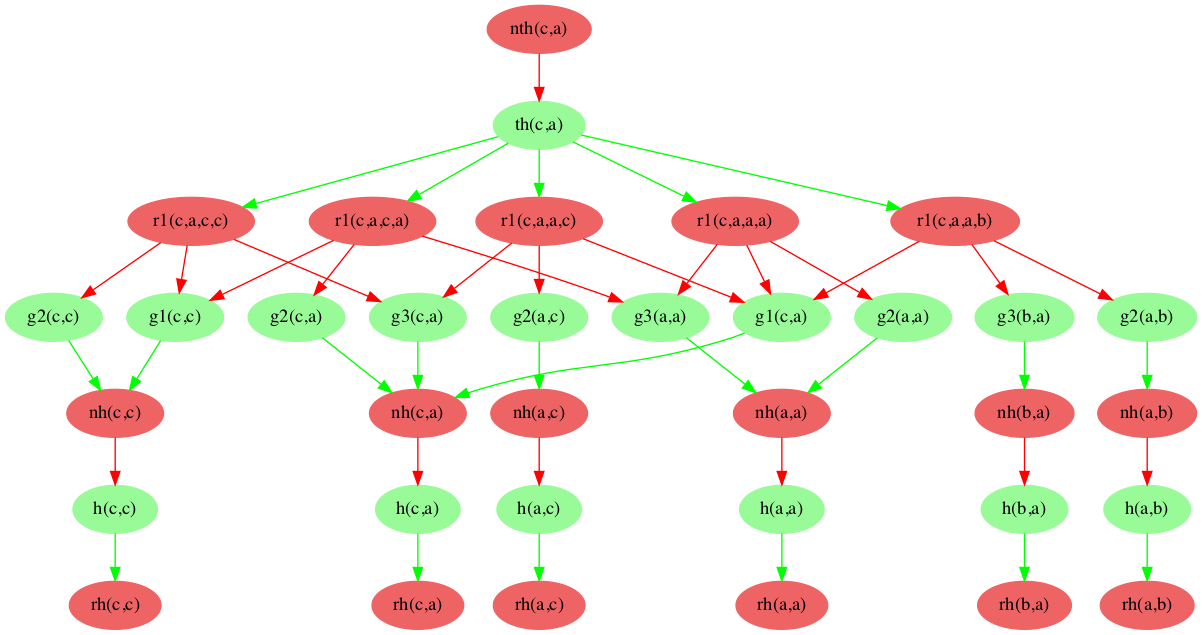

Hop(s) added: h(b,b). h(c,b). h(a,c).
th(c,a) Satisfied
Provenance Subgraph:


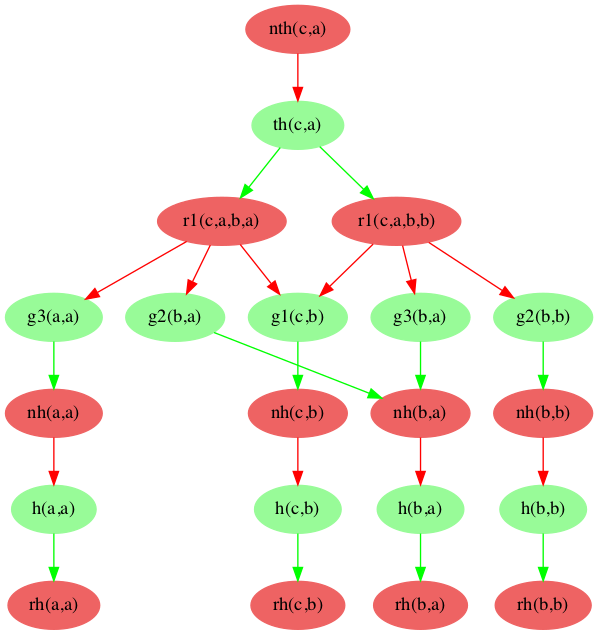

Hop(s) added: h(b,b). h(c,b). h(c,c).
th(c,a) Satisfied
Provenance Subgraph:


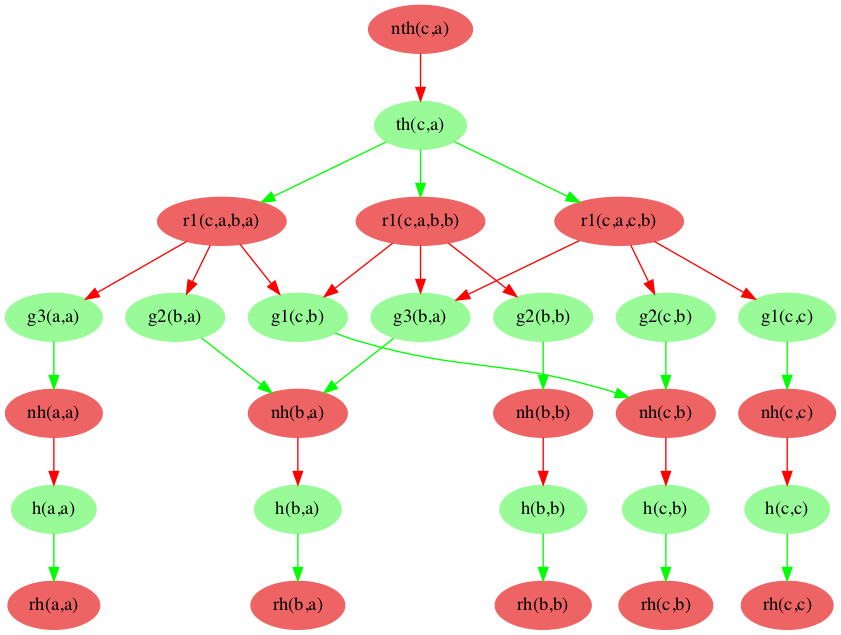

Hop(s) added: h(b,b). h(a,c). h(c,c).
th(c,a) Not satisfied
Provenance Subgraph:


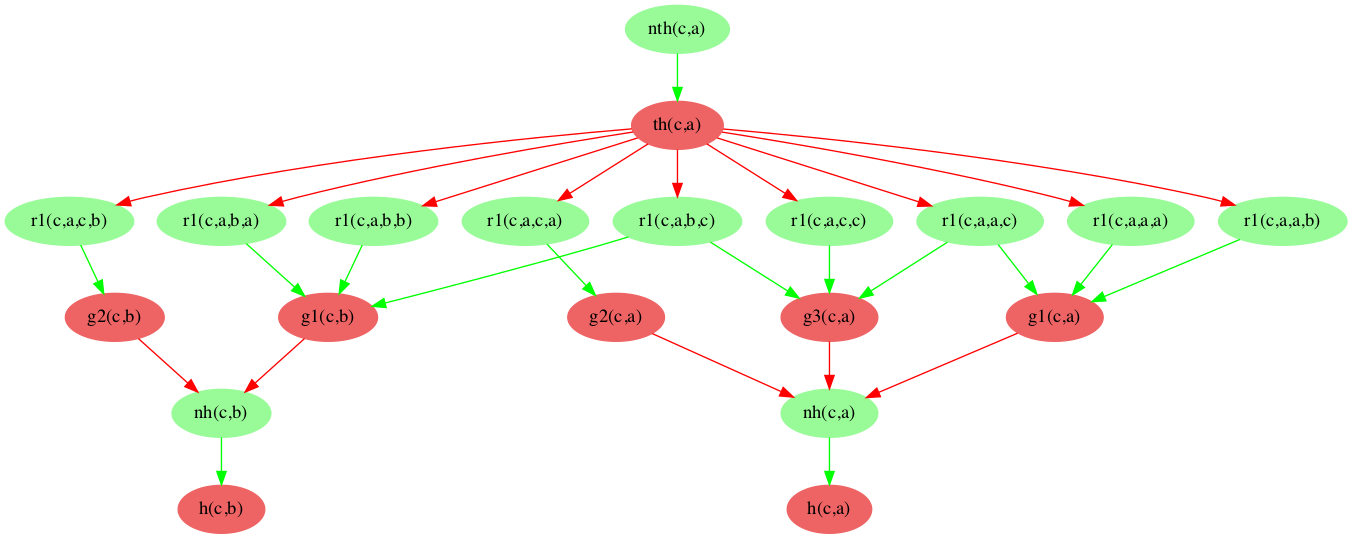

Hop(s) added: h(c,b). h(a,c). h(c,c).
th(c,a) Satisfied
Provenance Subgraph:


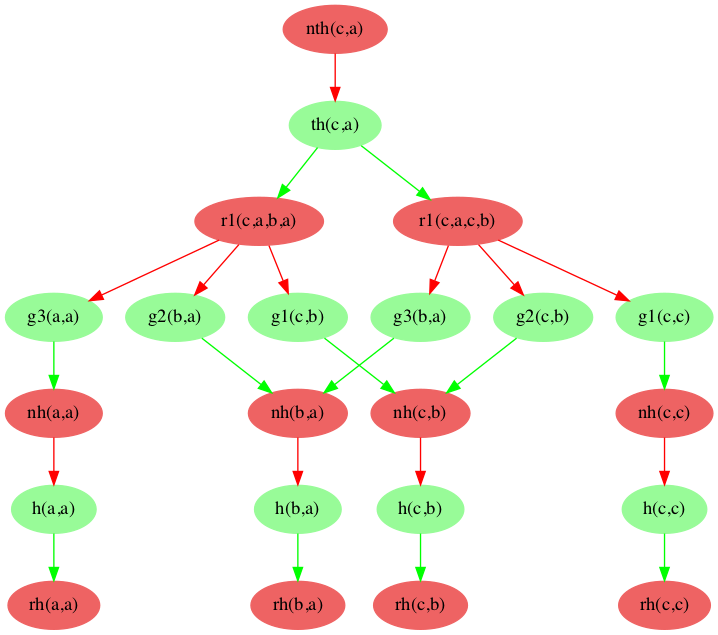

Hop(s) added: h(c,a). h(b,b). h(c,b). h(a,c).
th(c,a) Satisfied
Provenance Subgraph:


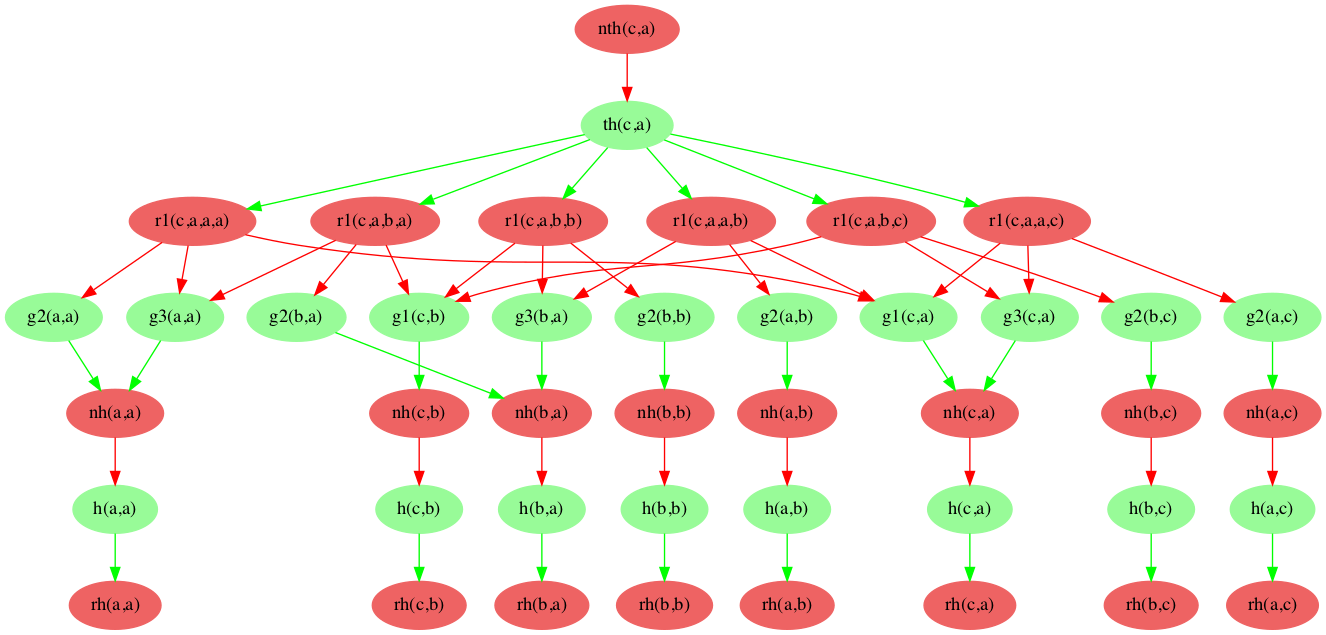

Hop(s) added: h(c,a). h(b,b). h(c,b). h(c,c).
th(c,a) Satisfied
Provenance Subgraph:


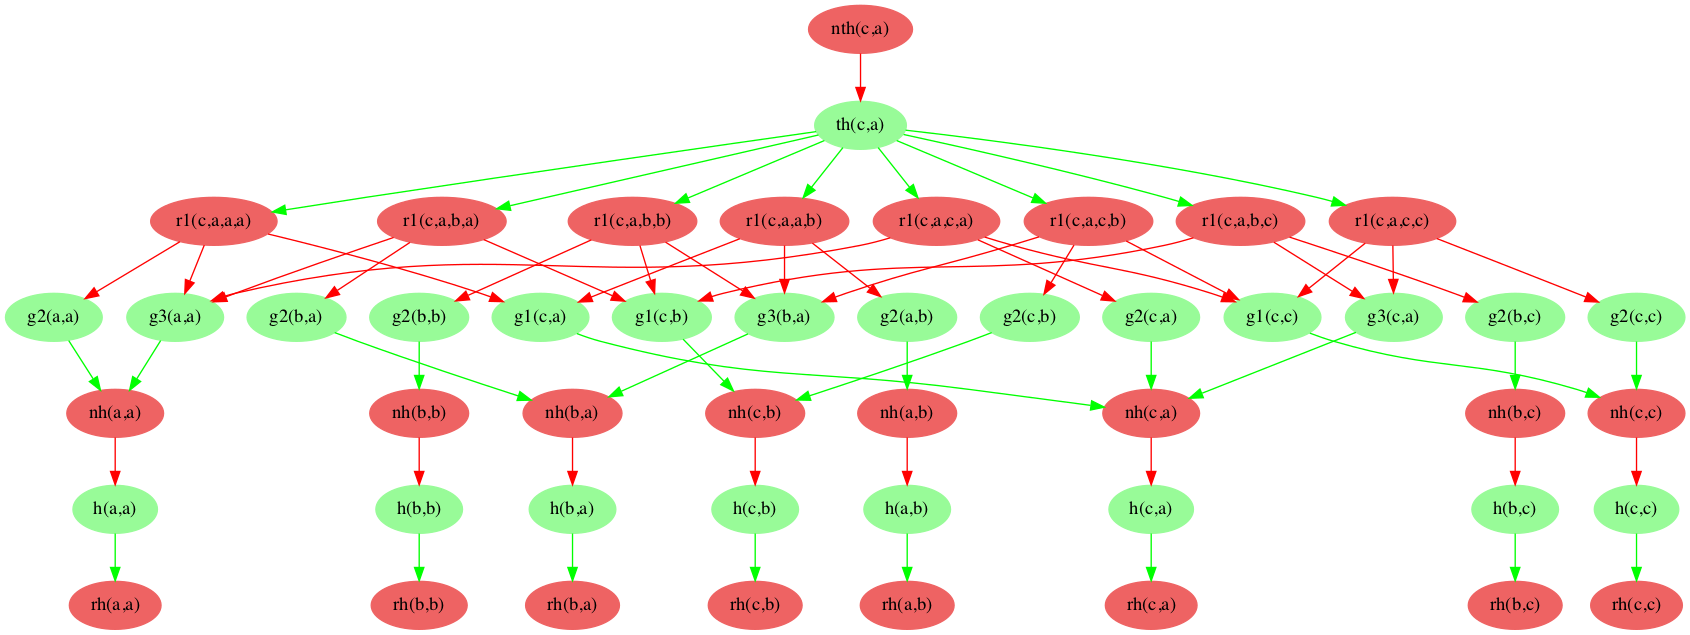

Hop(s) added: h(c,a). h(b,b). h(a,c). h(c,c).
th(c,a) Satisfied
Provenance Subgraph:


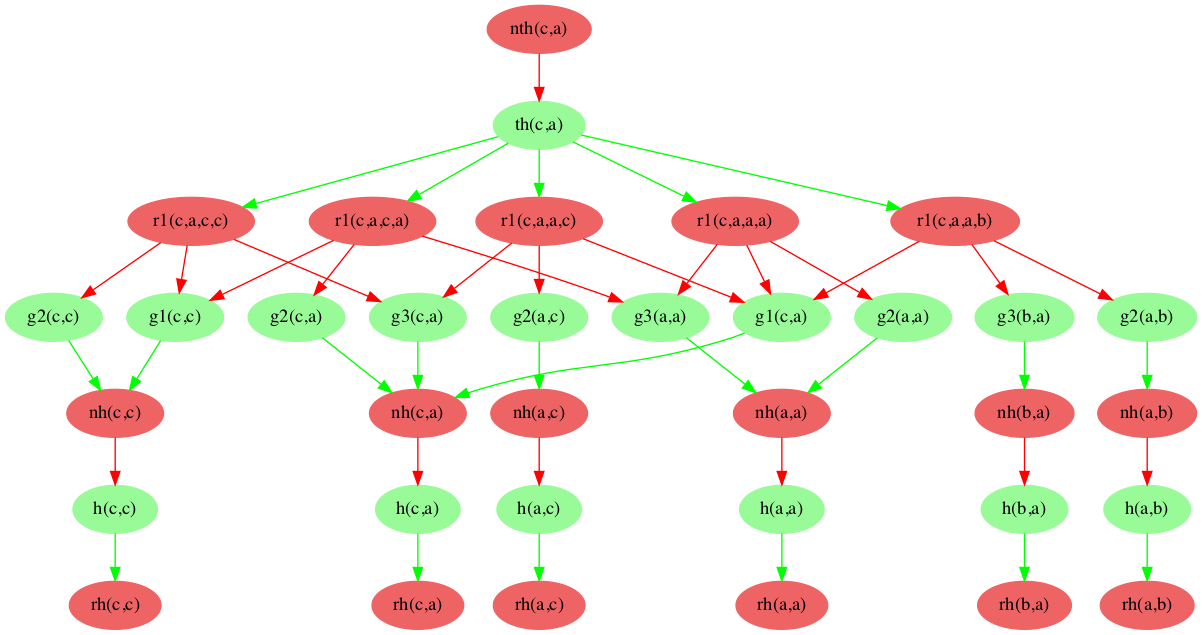

Hop(s) added: h(c,a). h(c,b). h(a,c). h(c,c).
th(c,a) Satisfied
Provenance Subgraph:


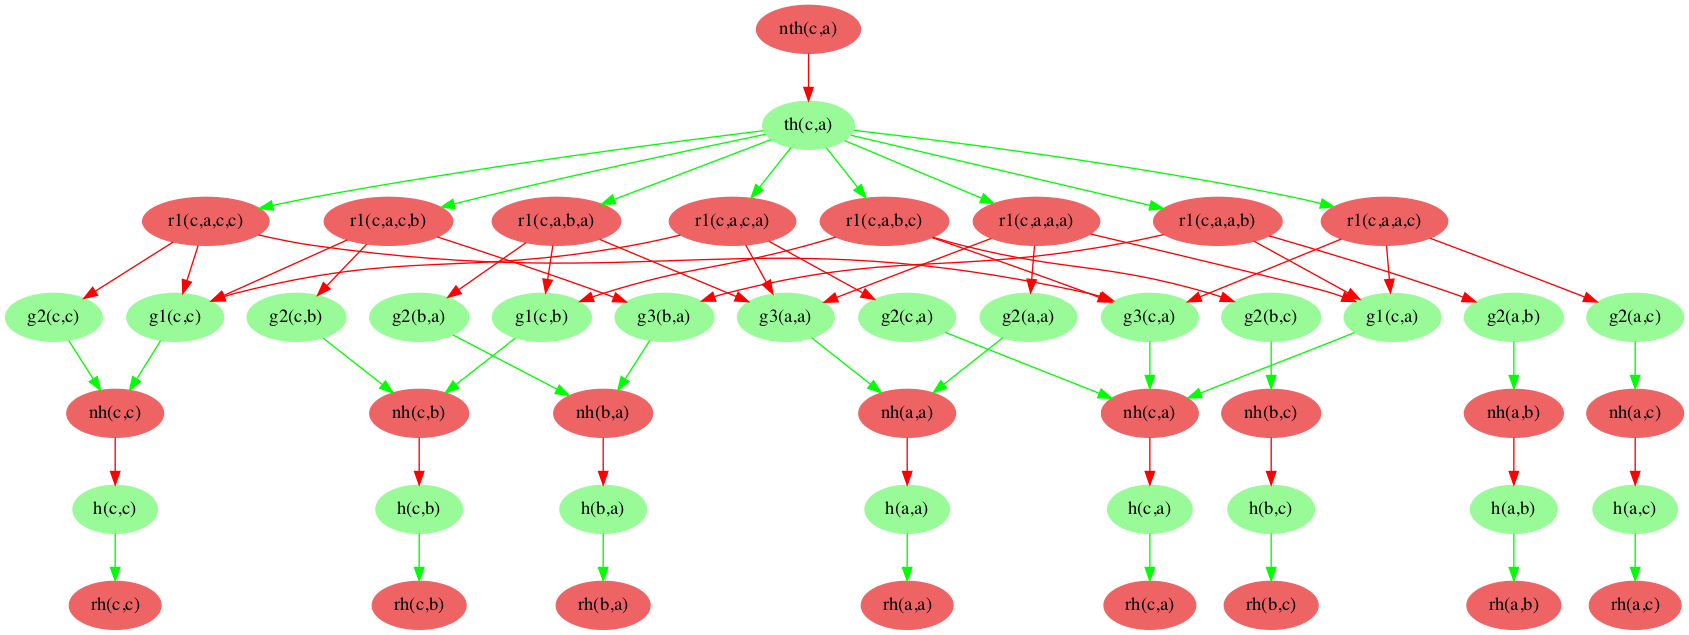

Hop(s) added: h(b,b). h(c,b). h(a,c). h(c,c).
th(c,a) Satisfied
Provenance Subgraph:


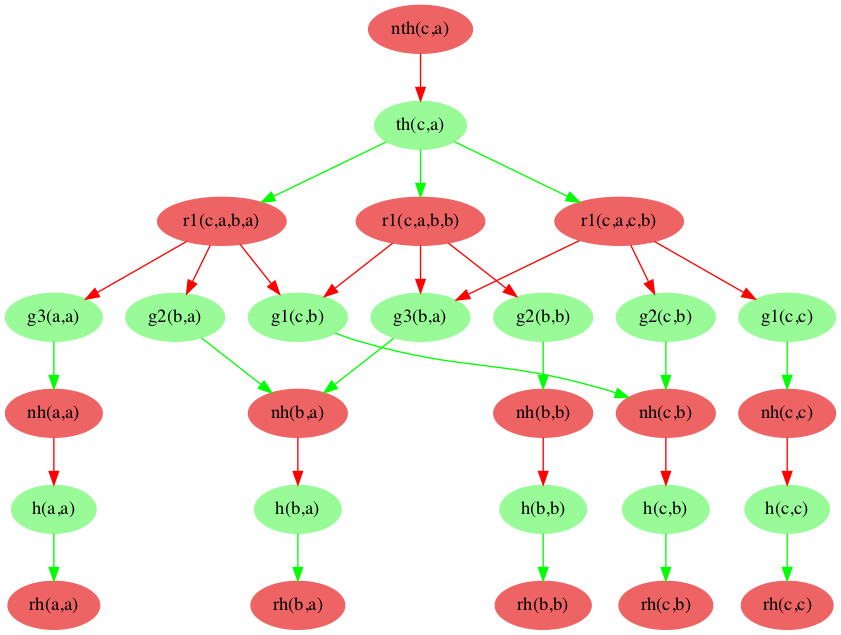

Hop(s) added: h(c,a). h(b,b). h(c,b). h(a,c). h(c,c).
th(c,a) Satisfied
Provenance Subgraph:


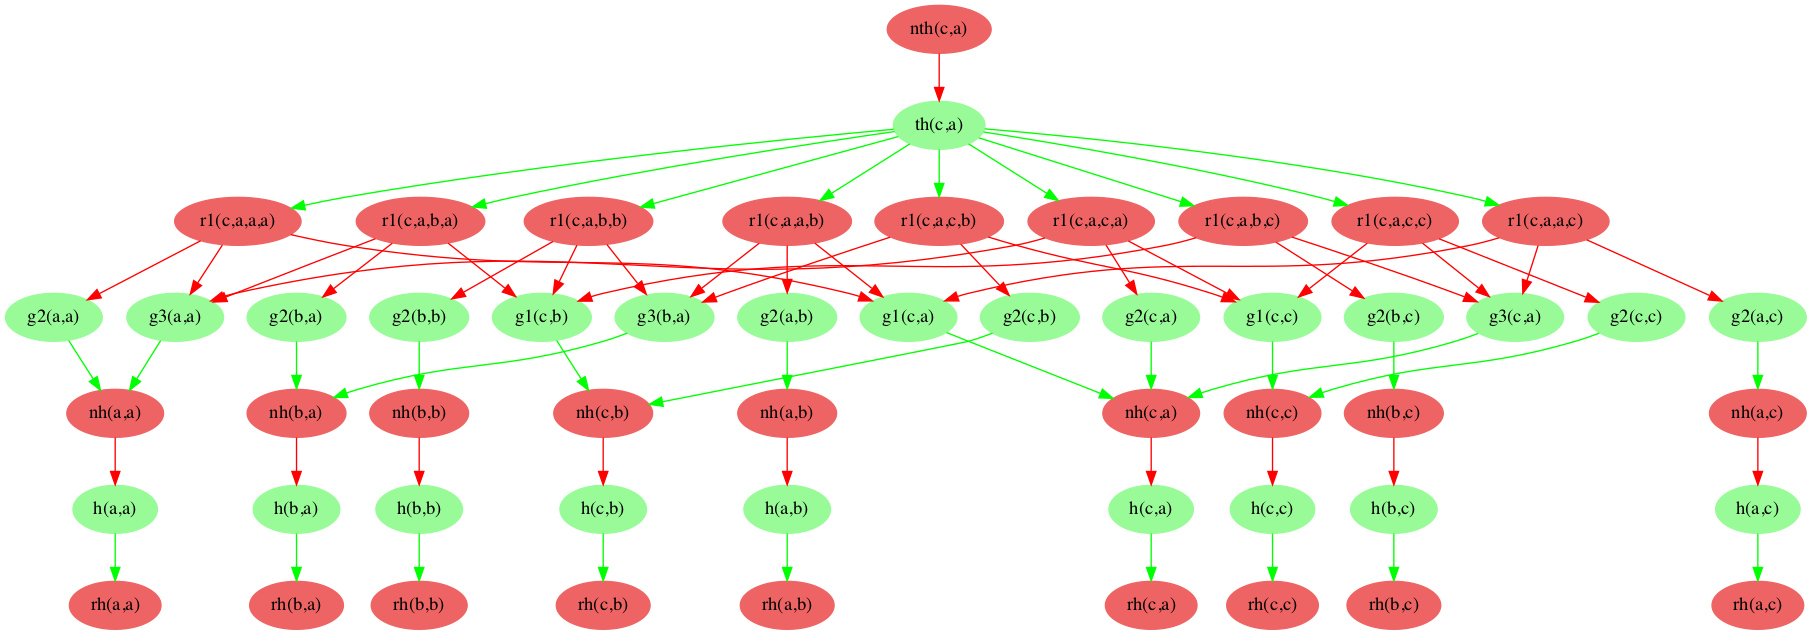

In [32]:
thop_what_if_prov_subgraphs = {}

for mh in mh_powerset:
    print("Hop(s) added:", *mh)
    lattice_node = set_to_node(mh)
    
    nth_node = get_prov_root_positive_node(*thop_node_to_check)
    
    new_3hop_inst = thop_prov_enc + "\n" + "\n".join(mh)
    new_3hop_exp = {}
    new_3hop_exp['asp_soln'], new_3hop_exp['meta_data'] = run_clingo(new_3hop_inst)
    new_3hop_exp['pw_rel_dfs'], new_3hop_exp['rel_schema'], new_3hop_exp['pw_objs'] \
        = load_worlds(new_3hop_exp['asp_soln'], new_3hop_exp['meta_data'], silent=True)
    
    thop_prov_graph = PWEVisualization.graphviz_from_meta_data(new_3hop_exp['pw_rel_dfs'], new_3hop_exp['meta_data']['graphviz'])
    remove_non_prov_edges(thop_prov_graph, inplace=True)
    thop_node_satisfied = nth_node in list(new_3hop_exp['pw_rel_dfs']['w_1']['x1'])
    
    what_if_prov_lattice.nodes[lattice_node]['style'] = 'filled'
    if thop_node_satisfied:
        print("{} Satisfied".format(nth_node))
        what_if_prov_lattice.nodes[lattice_node]['color'] = CONSISTENT_NODE_COLOR
        what_if_prov_lattice.nodes[lattice_node]['fillcolor'] = 'palegreen'
    else:
        print("{} Not satisfied".format(nth_node))
        what_if_prov_lattice.nodes[lattice_node]['color'] = INCONSISTENT_NODE_COLOR
        what_if_prov_lattice.nodes[lattice_node]['fillcolor'] = 'lightcoral'
    
    prov_subgraph = get_prov_subgraph(*thop_node_to_check, thop_prov_graph)
    thop_what_if_prov_subgraphs[lattice_node] =  prov_subgraph
    print("Provenance Subgraph:")
    display(draw(prov_subgraph))



Above, we have iterated over all possible hop facts subsets insertion to see what would happen to the evaluation of 3hop(c,a) if a certain subset of missing facts is added to the database.

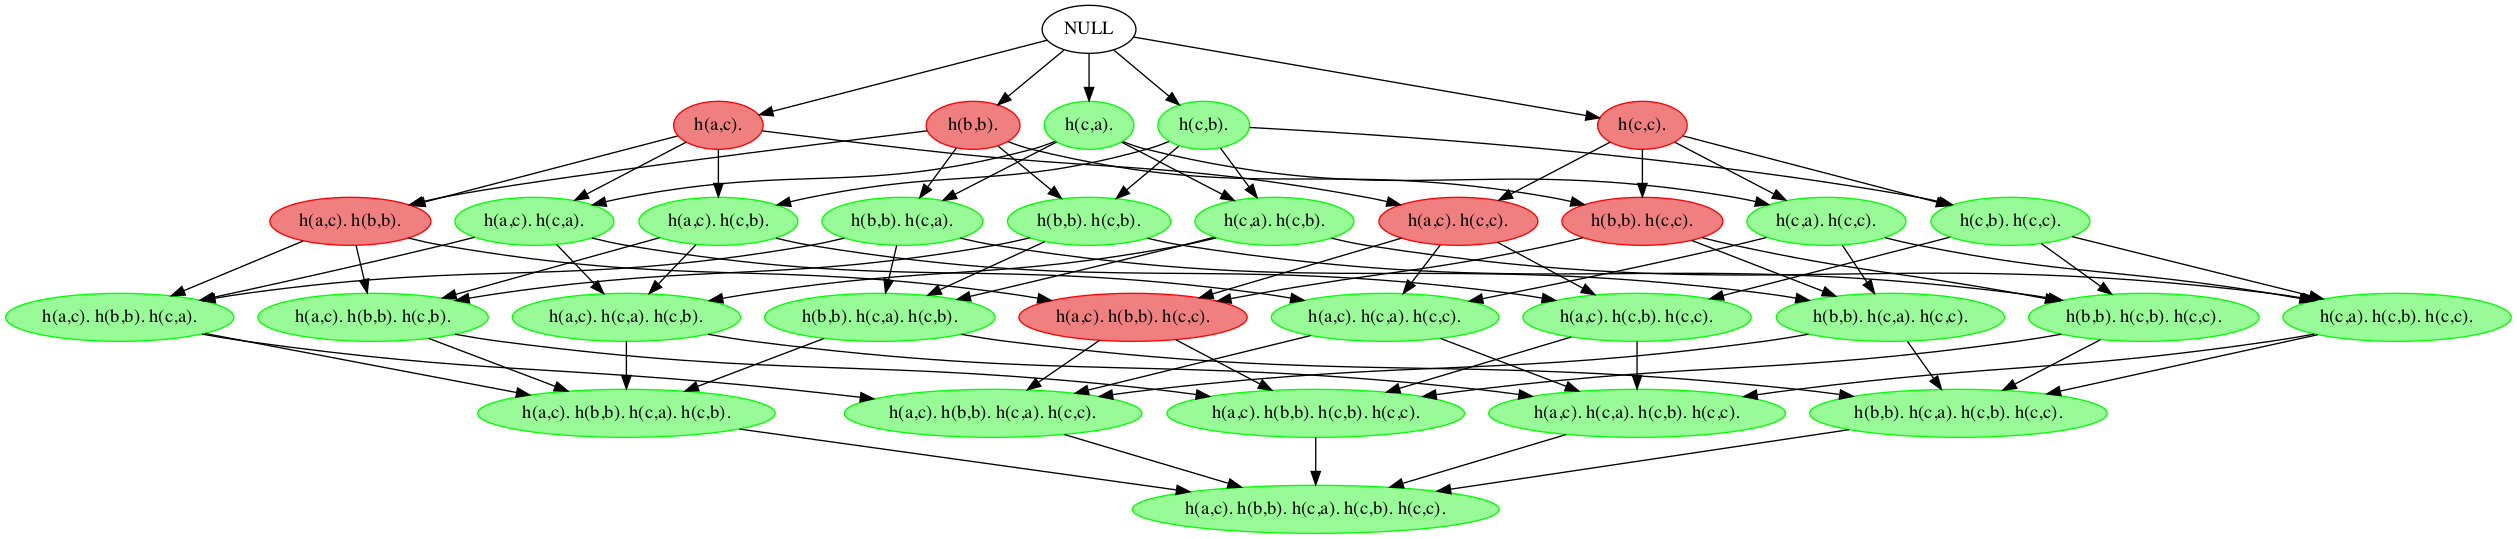

In [33]:
display(draw(what_if_prov_lattice))

Based on that we can create a lattice of the outputs, i.e. whether addition of a set of facts now satisfy 3hop(c,a). Note that if a node is "green" so will all its descendants and vice-versa for the "red" nodes.

We can observe that wou need one of h(c,a) and h(c,b) to be able to get 3hop(c,a).

#### What-if Provenance Analysis using WFS:

We can perform a similar analysis of what-if provenance using well-founded semantics models (3-valued models):

Let's assume the fact hop(c,a) is the one in focus, i.e. it could be either true of false. Given that we would need to see how this fact affect the other 3hop evaluations.

NOTE: Here we use DLV as our ASP system instead of Clingo because it supports WFS model evaluation which Clingo doesn't. We are able to use the clingo encoding from above directly since the syntax for both DLV and Clingo are very similar and in this case the Clingo encoding matches the DLV equivalent exactly.

In [34]:
%%dlv --run --donot-display_input -wfs -exp prov_wfs_exp -l thop_prov_enc

h(c,a) ; out(c,a).

Output:


'True: {h(a,a), h(a,b), h(b,a), h(b,c), d(a), d(b), d(c), m(nth(a,a),th(a,a)), m(th(a,a),r1(a,a,a,a)), m(th(a,a),r1(a,a,b,a)), m(th(a,a),r1(a,a,c,a)), m(th(a,a),r1(a,a,a,b)), m(th(a,a),r1(a,a,b,b)), m(th(a,a),r1(a,a,c,b)), m(th(a,a),r1(a,a,a,c)), m(th(a,a),r1(a,a,b,c)), m(th(a,a),r1(a,a,c,c)), m(nth(b,a),th(b,a)), m(th(b,a),r1(b,a,a,a)), m(th(b,a),r1(b,a,b,a)), m(th(b,a),r1(b,a,c,a)), m(th(b,a),r1(b,a,a,b)), m(th(b,a),r1(b,a,b,b)), m(th(b,a),r1(b,a,c,b)), m(th(b,a),r1(b,a,a,c)), m(th(b,a),r1(b,a,b,c)), m(th(b,a),r1(b,a,c,c)), m(nth(c,a),th(c,a)), m(th(c,a),r1(c,a,a,a)), m(th(c,a),r1(c,a,b,a)), m(th(c,a),r1(c,a,c,a)), m(th(c,a),r1(c,a,a,b)), m(th(c,a),r1(c,a,b,b)), m(th(c,a),r1(c,a,c,b)), m(th(c,a),r1(c,a,a,c)), m(th(c,a),r1(c,a,b,c)), m(th(c,a),r1(c,a,c,c)), m(nth(a,b),th(a,b)), m(th(a,b),r1(a,b,a,a)), m(th(a,b),r1(a,b,b,a)), m(th(a,b),r1(a,b,c,a)), m(th(a,b),r1(a,b,a,b)), m(th(a,b),r1(a,b,b,b)), m(th(a,b),r1(a,b,c,b)), m(th(a,b),r1(a,b,a,c)), m(th(a,b),r1(a,b,b,c)), m(th(a,b),r1(a,b,c,c)), m(nth(b,b),th(b,b)), m(th(b,b),r1(b,b,a,a)), m(th(b,b),r1(b,b,b,a)), m(th(b,b),r1(b,b,c,a)), m(th(b,b),r1(b,b,a,b)), m(th(b,b),r1(b,b,b,b)), m(th(b,b),r1(b,b,c,b)), m(th(b,b),r1(b,b,a,c)), m(th(b,b),r1(b,b,b,c)), m(th(b,b),r1(b,b,c,c)), m(nth(c,b),th(c,b)), m(th(c,b),r1(c,b,a,a)), m(th(c,b),r1(c,b,b,a)), m(th(c,b),r1(c,b,c,a)), m(th(c,b),r1(c,b,a,b)), m(th(c,b),r1(c,b,b,b)), m(th(c,b),r1(c,b,c,b)), m(th(c,b),r1(c,b,a,c)), m(th(c,b),r1(c,b,b,c)), m(th(c,b),r1(c,b,c,c)), m(nth(a,c),th(a,c)), m(th(a,c),r1(a,c,a,a)), m(th(a,c),r1(a,c,b,a)), m(th(a,c),r1(a,c,c,a)), m(th(a,c),r1(a,c,a,b)), m(th(a,c),r1(a,c,b,b)), m(th(a,c),r1(a,c,c,b)), m(th(a,c),r1(a,c,a,c)), m(th(a,c),r1(a,c,b,c)), m(th(a,c),r1(a,c,c,c)), m(nth(b,c),th(b,c)), m(th(b,c),r1(b,c,a,a)), m(th(b,c),r1(b,c,b,a)), m(th(b,c),r1(b,c,c,a)), m(th(b,c),r1(b,c,a,b)), m(th(b,c),r1(b,c,b,b)), m(th(b,c),r1(b,c,c,b)), m(th(b,c),r1(b,c,a,c)), m(th(b,c),r1(b,c,b,c)), m(th(b,c),r1(b,c,c,c)), m(nth(c,c),th(c,c)), m(th(c,c),r1(c,c,a,a)), m(th(c,c),r1(c,c,b,a)), m(th(c,c),r1(c,c,c,a)), m(th(c,c),r1(c,c,a,b)), m(th(c,c),r1(c,c,b,b)), m(th(c,c),r1(c,c,c,b)), m(th(c,c),r1(c,c,a,c)), m(th(c,c),r1(c,c,b,c)), m(th(c,c),r1(c,c,c,c)), m(nh(a,a),h(a,a)), m(h(a,a),rh(a,a)), m(nh(b,a),h(b,a)), m(h(b,a),rh(b,a)), m(nh(c,a),h(c,a)), m(nh(a,b),h(a,b)), m(h(a,b),rh(a,b)), m(nh(b,b),h(b,b)), m(nh(c,b),h(c,b)), m(nh(a,c),h(a,c)), m(nh(b,c),h(b,c)), m(h(b,c),rh(b,c)), m(nh(c,c),h(c,c)), m(r1(a,a,a,a),g1(a,a)), m(r1(a,a,a,a),g2(a,a)), m(r1(a,a,a,a),g3(a,a)), m(r1(b,a,a,a),g1(b,a)), m(r1(b,a,a,a),g2(a,a)), m(r1(b,a,a,a),g3(a,a)), m(r1(c,a,a,a),g1(c,a)), m(r1(c,a,a,a),g2(a,a)), m(r1(c,a,a,a),g3(a,a)), m(r1(a,b,a,a),g1(a,a)), m(r1(a,b,a,a),g2(a,a)), m(r1(a,b,a,a),g3(a,b)), m(r1(b,b,a,a),g1(b,a)), m(r1(b,b,a,a),g2(a,a)), m(r1(b,b,a,a),g3(a,b)), m(r1(c,b,a,a),g1(c,a)), m(r1(c,b,a,a),g2(a,a)), m(r1(c,b,a,a),g3(a,b)), m(r1(a,c,a,a),g1(a,a)), m(r1(a,c,a,a),g2(a,a)), m(r1(a,c,a,a),g3(a,c)), m(r1(b,c,a,a),g1(b,a)), m(r1(b,c,a,a),g2(a,a)), m(r1(b,c,a,a),g3(a,c)), m(r1(c,c,a,a),g1(c,a)), m(r1(c,c,a,a),g2(a,a)), m(r1(c,c,a,a),g3(a,c)), m(r1(a,a,b,a),g1(a,b)), m(r1(a,a,b,a),g2(b,a)), m(r1(a,a,b,a),g3(a,a)), m(r1(b,a,b,a),g1(b,b)), m(r1(b,a,b,a),g2(b,a)), m(r1(b,a,b,a),g3(a,a)), m(r1(c,a,b,a),g1(c,b)), m(r1(c,a,b,a),g2(b,a)), m(r1(c,a,b,a),g3(a,a)), m(r1(a,b,b,a),g1(a,b)), m(r1(a,b,b,a),g2(b,a)), m(r1(a,b,b,a),g3(a,b)), m(r1(b,b,b,a),g1(b,b)), m(r1(b,b,b,a),g2(b,a)), m(r1(b,b,b,a),g3(a,b)), m(r1(c,b,b,a),g1(c,b)), m(r1(c,b,b,a),g2(b,a)), m(r1(c,b,b,a),g3(a,b)), m(r1(a,c,b,a),g1(a,b)), m(r1(a,c,b,a),g2(b,a)), m(r1(a,c,b,a),g3(a,c)), m(r1(b,c,b,a),g1(b,b)), m(r1(b,c,b,a),g2(b,a)), m(r1(b,c,b,a),g3(a,c)), m(r1(c,c,b,a),g1(c,b)), m(r1(c,c,b,a),g2(b,a)), m(r1(c,c,b,a),g3(a,c)), m(r1(a,a,c,a),g1(a,c)), m(r1(a,a,c,a),g2(c,a)), m(r1(a,a,c,a),g3(a,a)), m(r1(b,a,c,a),g1(b,c)), m(r1(b,a,c,a),g2(c,a)), m(r1(b,a,c,a),g3(a,a)), m(r1(c,a,c,a),g1(c,c)), m(r1(c,a,c,a),g2(c,a)), m(r1(c,a,c,a),g3(a,a)), m(r1(a,b,c,a),g1(a,c)), m(r1(a,b,c,a),g2(c,a)), m(

In [35]:
prov_wfs_exp['pw_rel_dfs'], prov_wfs_exp['rel_schema'], prov_wfs_exp['pw_objs'] = load_worlds(prov_wfs_exp['asp_soln'], prov_wfs_exp['meta_data'], reasoner='dlv')

In [36]:
prov_wfs_exp['pw_rel_dfs']['non_p_3']

wfs_status    x1           x2           x3
0         true  gray      th(a,a)  r1(a,a,c,a)
1         true  gray      th(a,a)  r1(a,a,b,b)
2         true  gray      th(a,a)  r1(a,a,c,b)
3         true  gray      th(a,a)  r1(a,a,a,c)
4         true  gray      th(a,a)  r1(a,a,c,c)
5         true  gray      th(b,a)  r1(b,a,b,a)
6         true  gray      th(b,a)  r1(b,a,b,b)
7         true  gray      th(b,a)  r1(b,a,c,b)
8         true  gray      th(b,a)  r1(b,a,a,c)
9         true  gray      th(b,a)  r1(b,a,b,c)
10        true  gray      th(b,a)  r1(b,a,c,c)
11        true  gray      th(a,b)  r1(a,b,c,a)
12        true  gray      th(a,b)  r1(a,b,a,b)
13        true  gray      th(a,b)  r1(a,b,b,b)
14        true  gray      th(a,b)  r1(a,b,c,b)
15        true  gray      th(a,b)  r1(a,b,a,c)
16        true  gray      th(a,b)  r1(a,b,b,c)
17        true  gray      th(a,b)  r1(a,b,c,c)
18        true  gray      th(b,b)  r1(b,b,b,a)
19        true  gray      th(b,b)  r1(b,b,a,b)
20        true  gray      th(b,b)  r1(b,b,b,b)
21        true  gray      th(b,b)  r1(b,b,c,b)
22        true  gray      th(b,b)  r1(b,b,a,c)
23        true  gray      th(b,b)  r1(b,b,b,c)
24        true  gray      th(b,b)  r1(b,b,c,c)
25        true  gray      th(a,c)  r1(a,c,a,a)
26        true  gray      th(a,c)  r1(a,c,b,a)
27        true  gray      th(a,c)  r1(a,c,c,a)
28        true  gray      th(a,c)  r1(a,c,b,b)
29        true  gray      th(a,c)  r1(a,c,c,b)
..         ...   ...          ...          ...
153  undefined  gray  r1(b,b,c,a)      g2(c,a)
154  undefined  gray  r1(b,b,c,a)      g3(a,b)
155  undefined  gray  r1(c,b,c,a)      g2(c,a)
156  undefined  gray  r1(a,c,c,a)      g2(c,a)
157  undefined  gray  r1(b,c,c,a)      g2(c,a)
158  undefined  gray  r1(c,c,c,a)      g2(c,a)
159  undefined  gray  r1(c,a,a,b)      g1(c,a)
160  undefined  gray  r1(c,a,a,b)      g2(a,b)
161  undefined  gray  r1(c,a,a,b)      g3(b,a)
162  undefined  gray  r1(c,b,a,b)      g1(c,a)
163  undefined  gray  r1(c,c,a,b)      g1(c,a)
164  undefined  gray  r1(c,c,a,b)      g2(a,b)
165  undefined  gray  r1(c,c,a,b)      g3(b,c)
166  undefined  gray  r1(a,a,a,c)      g3(c,a)
167  undefined  gray  r1(b,a,a,c)      g3(c,a)
168  undefined  gray  r1(c,a,a,c)      g1(c,a)
169  undefined  gray  r1(c,a,a,c)      g3(c,a)
170  undefined  gray  r1(c,b,a,c)      g1(c,a)
171  undefined  gray  r1(c,c,a,c)      g1(c,a)
172  undefined  gray  r1(a,a,b,c)      g1(a,b)
173  undefined  gray  r1(a,a,b,c)      g2(b,c)
174  undefined  gray  r1(a,a,b,c)      g3(c,a)
175  undefined  gray  r1(b,a,b,c)      g3(c,a)
176  undefined  gray  r1(c,a,b,c)      g3(c,a)
177  undefined  gray  r1(a,a,c,c)      g3(c,a)
178  undefined  gray  r1(b,a,c,c)      g3(c,a)
179  undefined  gray  r1(c,a,c,c)      g3(c,a)
180  undefined  gray      g1(c,a)      nh(c,a)
181  undefined  gray      g2(c,a)      nh(c,a)
182  undefined  gray      g3(c,a)      nh(c,a)

[183 rows x 4 columns]

In [37]:
prov_wfs_exp['pw_rel_dfs']['p_3']

wfs_status     x1           x2           x3
0         true  green      th(a,a)  r1(a,a,a,a)
1         true  green      th(a,a)  r1(a,a,b,a)
2         true  green      th(a,a)  r1(a,a,a,b)
3         true  green      th(b,a)  r1(b,a,a,a)
4         true  green      th(b,a)  r1(b,a,a,b)
5         true  green      th(a,b)  r1(a,b,a,a)
6         true  green      th(a,b)  r1(a,b,b,a)
7         true  green      th(b,b)  r1(b,b,a,a)
8         true  green      th(a,c)  r1(a,c,a,b)
9         true  green      th(b,c)  r1(b,c,a,b)
10        true  green       h(a,a)      rh(a,a)
11        true  green       h(b,a)      rh(b,a)
12        true  green       h(a,b)      rh(a,b)
13        true  green      nh(b,b)       h(b,b)
14        true  green      nh(c,b)       h(c,b)
15        true  green      nh(a,c)       h(a,c)
16        true  green       h(b,c)      rh(b,c)
17        true  green      nh(c,c)       h(c,c)
18        true  green  r1(a,c,a,a)      g3(a,c)
19        true  green  r1(b,c,a,a)      g3(a,c)
20        true  green  r1(c,c,a,a)      g3(a,c)
21        true  green  r1(b,a,b,a)      g1(b,b)
22        true  green  r1(c,a,b,a)      g1(c,b)
23        true  green  r1(b,b,b,a)      g1(b,b)
24        true  green  r1(c,b,b,a)      g1(c,b)
25        true  green  r1(a,c,b,a)      g3(a,c)
26        true  green  r1(b,c,b,a)      g1(b,b)
27        true  green  r1(b,c,b,a)      g3(a,c)
28        true  green  r1(c,c,b,a)      g1(c,b)
29        true  green  r1(c,c,b,a)      g3(a,c)
..         ...    ...          ...          ...
257  undefined    red      th(c,c)  r1(c,c,b,b)
258  undefined    red      th(c,c)  r1(c,c,c,b)
259  undefined    red      th(c,c)  r1(c,c,a,c)
260  undefined    red      th(c,c)  r1(c,c,b,c)
261  undefined    red      th(c,c)  r1(c,c,c,c)
262  undefined    red      nh(c,a)       h(c,a)
263  undefined    red  r1(c,a,a,a)      g1(c,a)
264  undefined    red  r1(c,a,a,a)      g2(a,a)
265  undefined    red  r1(c,a,a,a)      g3(a,a)
266  undefined    red  r1(c,b,a,a)      g1(c,a)
267  undefined    red  r1(c,b,a,a)      g2(a,a)
268  undefined    red  r1(c,b,a,a)      g3(a,b)
269  undefined    red  r1(b,a,c,a)      g1(b,c)
270  undefined    red  r1(b,a,c,a)      g2(c,a)
271  undefined    red  r1(b,a,c,a)      g3(a,a)
272  undefined    red  r1(b,b,c,a)      g1(b,c)
273  undefined    red  r1(b,b,c,a)      g2(c,a)
274  undefined    red  r1(b,b,c,a)      g3(a,b)
275  undefined    red  r1(c,a,a,b)      g1(c,a)
276  undefined    red  r1(c,a,a,b)      g2(a,b)
277  undefined    red  r1(c,a,a,b)      g3(b,a)
278  undefined    red  r1(c,c,a,b)      g1(c,a)
279  undefined    red  r1(c,c,a,b)      g2(a,b)
280  undefined    red  r1(c,c,a,b)      g3(b,c)
281  undefined    red  r1(a,a,b,c)      g1(a,b)
282  undefined    red  r1(a,a,b,c)      g2(b,c)
283  undefined    red  r1(a,a,b,c)      g3(c,a)
284  undefined    red      g1(c,a)      nh(c,a)
285  undefined    red      g2(c,a)      nh(c,a)
286  undefined    red      g3(c,a)      nh(c,a)

[287 rows x 4 columns]

In [38]:
prov_wfs_exp['pw_rel_dfs']['w_1']

wfs_status           x1
0         true      th(a,a)
1         true  r1(a,a,c,a)
2         true  r1(a,a,b,b)
3         true  r1(a,a,c,b)
4         true  r1(a,a,a,c)
5         true  r1(a,a,c,c)
6         true      th(b,a)
7         true  r1(b,a,b,a)
8         true  r1(b,a,b,b)
9         true  r1(b,a,c,b)
10        true  r1(b,a,a,c)
11        true  r1(b,a,b,c)
12        true  r1(b,a,c,c)
13        true  r1(c,a,b,a)
14        true  r1(c,a,c,a)
15        true  r1(c,a,b,b)
16        true  r1(c,a,c,b)
17        true  r1(c,a,a,c)
18        true  r1(c,a,b,c)
19        true  r1(c,a,c,c)
20        true      th(a,b)
21        true  r1(a,b,c,a)
22        true  r1(a,b,a,b)
23        true  r1(a,b,b,b)
24        true  r1(a,b,c,b)
25        true  r1(a,b,a,c)
26        true  r1(a,b,b,c)
27        true  r1(a,b,c,c)
28        true      th(b,b)
29        true  r1(b,b,b,a)
..         ...          ...
78        true      g1(a,a)
79        true      g2(a,a)
80        true      g3(a,a)
81        true      g1(b,a)
82        true      g3(a,b)
83        true      g1(a,b)
84        true      g2(b,a)
85        true      g1(b,c)
86        true      g2(a,b)
87        true      g3(b,a)
88        true      g3(b,c)
89        true      g2(b,c)
90   undefined  r1(a,a,b,c)
91   undefined  r1(b,a,c,a)
92   undefined      th(c,a)
93   undefined     nth(c,a)
94   undefined  r1(c,a,a,a)
95   undefined  r1(c,a,a,b)
96   undefined  r1(b,b,c,a)
97   undefined      th(c,b)
98   undefined     nth(c,b)
99   undefined  r1(c,b,a,a)
100  undefined      th(c,c)
101  undefined     nth(c,c)
102  undefined  r1(c,c,a,b)
103  undefined       h(c,a)
104  undefined      nh(c,a)
105  undefined      g1(c,a)
106  undefined      g2(c,a)
107  undefined      g3(c,a)

[108 rows x 2 columns]

As earlier, we can create a provenance graph. This time, many of the nodes are in the third or "undecided" state, i.e. they could be either true or false, based on whether or not hop(c,a) is TRUE or FALSE.

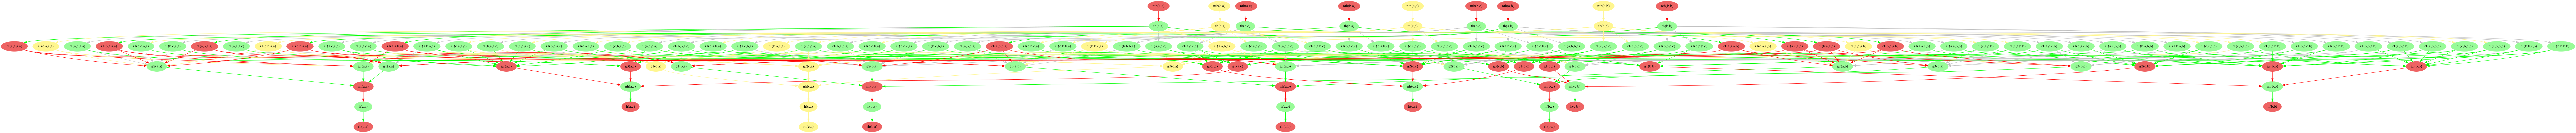

In [39]:
wfs_prov_graph = draw_wfs_prov_graph(prov_wfs_exp)        
draw(wfs_prov_graph)

In [40]:
remove_non_prov_edges(wfs_prov_graph, inplace=True)

Below is the provenance information for the evaluation of 3hop(a,a).

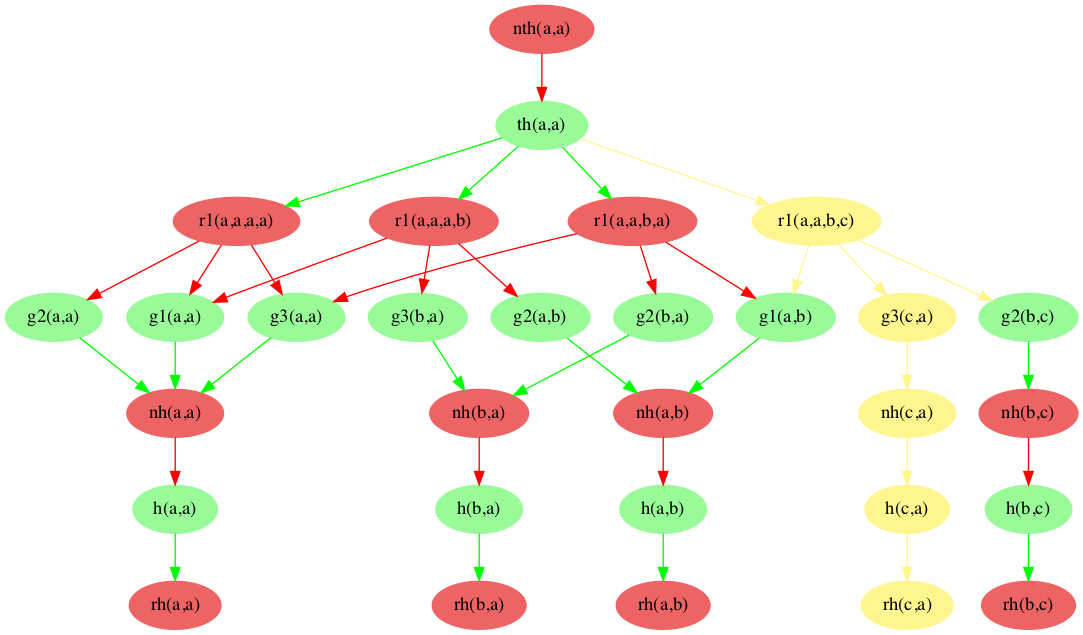

In [41]:
draw(get_prov_subgraph('a', 'a', wfs_prov_graph))

In [ ]:
# draw(get_prov_subgraph('a', 'a', wfs_prov_graph), filename='what-if-prov-th-aa.pdf', show=False)

As we can see, 3hop(a,a) is TRUE i.e. it doesn't depend on the true-ness of hop(c,a). It being true would give another proof for it's true-ness, but isn't needed.

Now, let's see the provenance of the 3hop(c,a) evaluation.

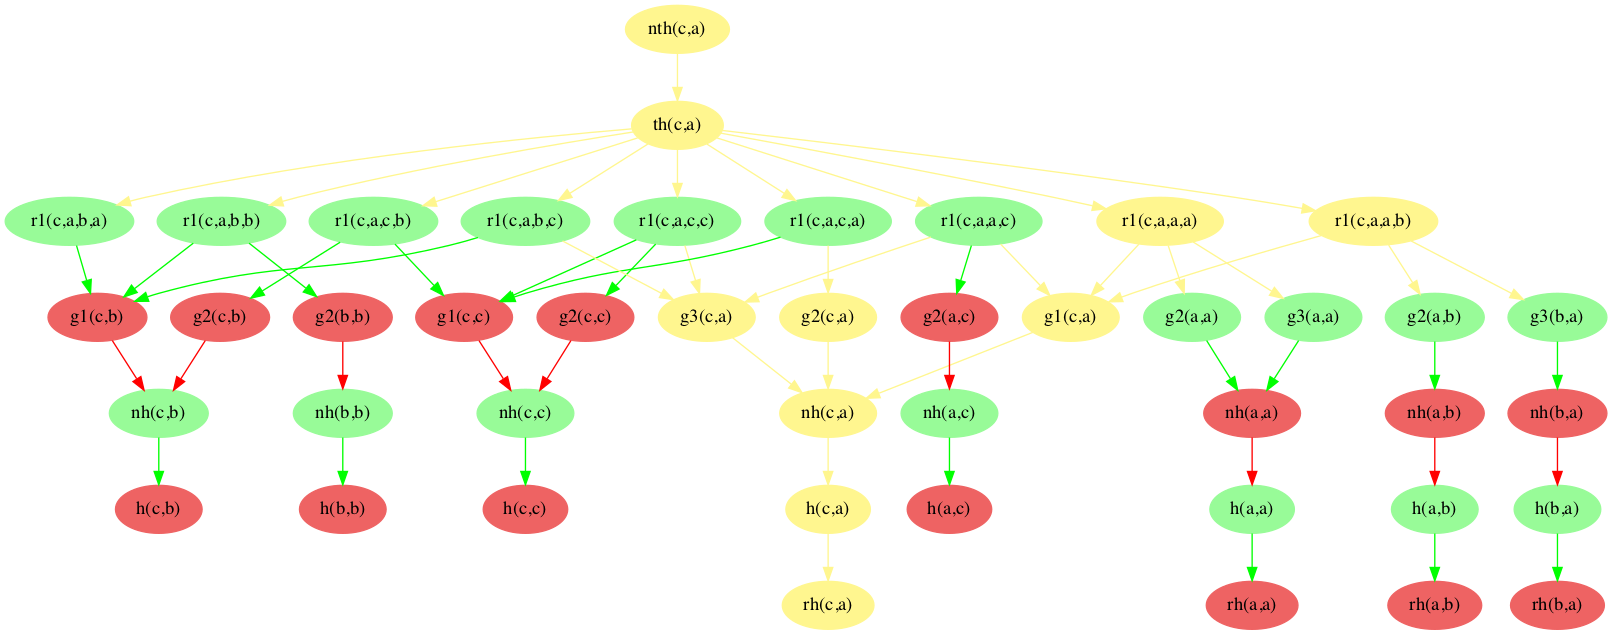

In [43]:
draw(get_prov_subgraph('c', 'a', wfs_prov_graph))

In [ ]:
# draw(get_prov_subgraph('c', 'a', wfs_prov_graph), filename='what-if-prov-th-ca.pdf', show=False)

Here, we can see that the asserted truth value of hop(c,a) is decisive in deciding if 3hop(c,a) will be true. (We also already know this from the other what-if prov experiment). If hop(c,a) were true, the "provenance" would consist (roughly) of the yellow nodes i.e. the r1 assignments in yellow and their goals. Note that their subgoals are all either already green or yellow (undecided) and they would be true if hop(c,a) were true. This already gives us both the why-provenance and why-not provenance for 3hop(c,a). If hop(c,a) is true, then we get the subgraph with yellow nodes (and their subgoals), and if not, we get the entire subgraph above, except the yellow rule assignment nodes would be green, the yellow subgoal nodes would be red and so on.

As a sanity check, here is the why-provenance for 3hop(c,a) if hop(c,a) were true (from the after-the-fact-addition what-if provenance analysis). As we can see, this matches exactly as we expected to the WFS-based analysis.

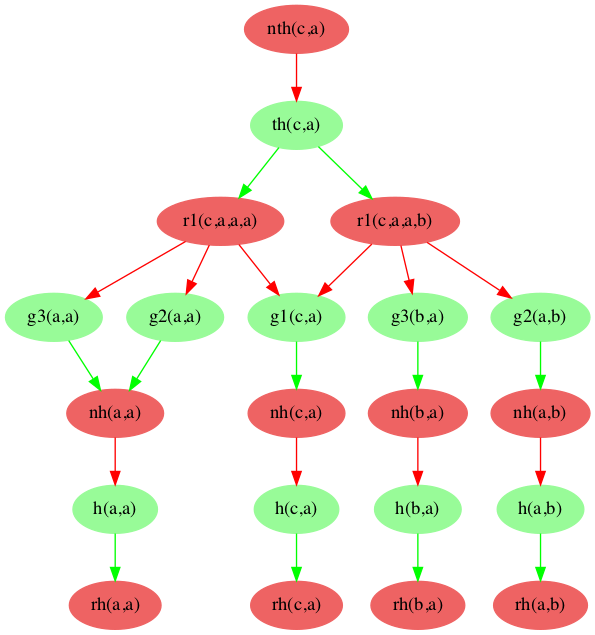

In [45]:
draw(thop_what_if_prov_subgraphs['h(c,a).'])